# MNA Workshop 
#### Week 1 Day 2 - Model Fitting 
##### This scripte was done with help of NMA course, which provided most of the code for participants to pracyice computational neuroscience tools. In this part, I learned how to fit computational models to experimental data and evaluate if they truly explain behavior or neural activity. There covered such topics as parameter estimation, uncertainty, and model comparison, focusing on regression models as a core example, and learned how to test hypotheses by comparing models of different complexity and assessing how model parameters vary across conditions or populations.
##### Tutorial 1 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We’ll finish our exploration of regression models by generalizing to multiple linear regression and polynomial regression (Tutorial 4). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 5) and Cross Validation for model selection (Tutorial 6).

### Tutorial 1: Linear regression with MSE
### Section 1: Mean Squared Error
##### Here we will (1) Define a linear model and generate some simulated data from this underlying linear model; and (2) Fit linear regression to the simulated data by minimizing MSE, and recover the linear weight.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [18]:
# @title Plotting Functions

def plot_observed_vs_predicted(x, y, y_hat, theta_hat):
  """ Plot observed vs predicted data

  Args:
    x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values
    theta_hat (ndarray):
  """
  fig, ax = plt.subplots()
  ax.scatter(x, y, label='Observed')  # our data scatter plot
  ax.plot(x, y_hat, color='r', label='Fit')  # our estimated model
  # plot residuals
  ymin = np.minimum(y, y_hat)
  ymax = np.maximum(y, y_hat)
  ax.vlines(x, ymin, ymax, 'g', alpha=0.5, label='Residuals')
  ax.set(
      title=fr"$\hat{{\theta}}$ = {theta_hat:0.2f}, MSE = {np.mean((y - y_hat)**2):.2f}",
      xlabel='x',
      ylabel='y'
  )
  ax.legend()
  plt.show()

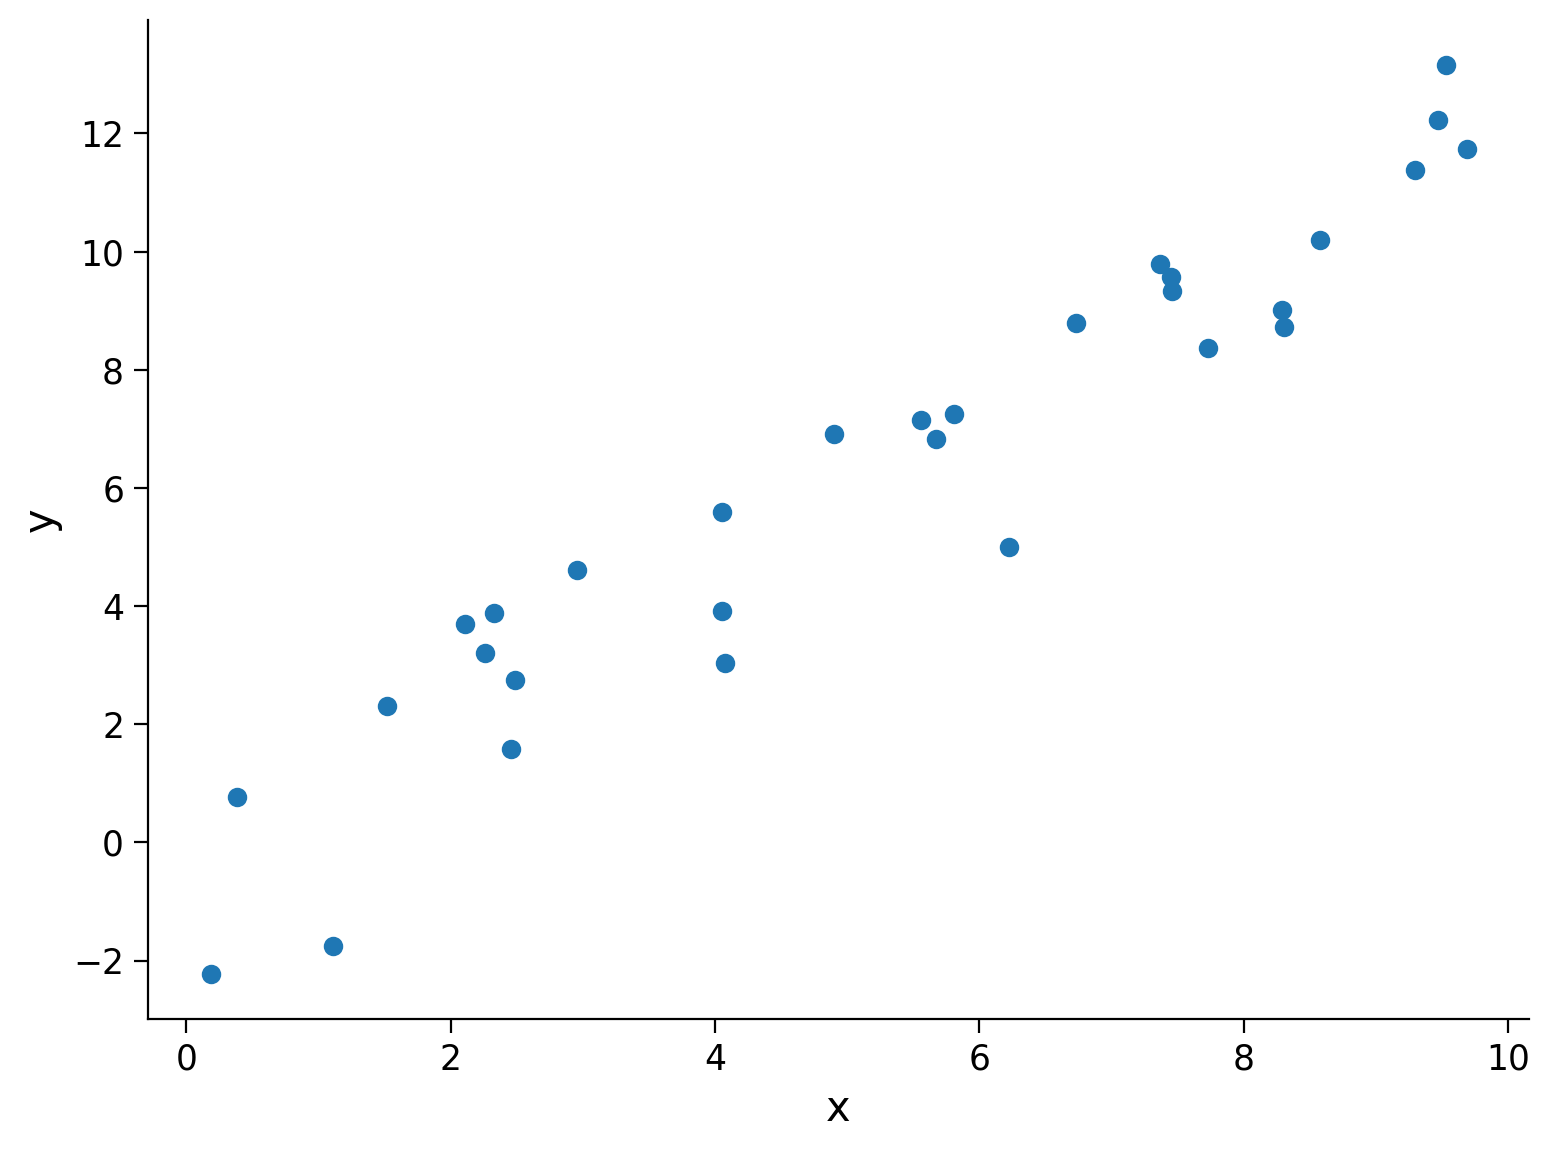

In [7]:
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 30

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

# Plot the results
fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

In [10]:
# to compute MSE
def mse(x, y, theta_hat):
  """
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta_hat (float): An estimate of the slope parameter

  Returns:
    float: The mean squared error of the data with the estimated parameter.
  """
  
  # Compute the estimated y
  y_hat = theta_hat * x

  # Compute mean squared error
  mse = np.mean((y - y_hat)**2)

  return mse


theta_hats = [0.75, 1.0, 1.5]
for theta_hat in theta_hats:
  print(f"theta_hat of {theta_hat} has an MSE of {mse(x, y, theta_hat):.2f}")

theta_hat of 0.75 has an MSE of 9.08
theta_hat of 1.0 has an MSE of 3.01
theta_hat of 1.5 has an MSE of 4.52


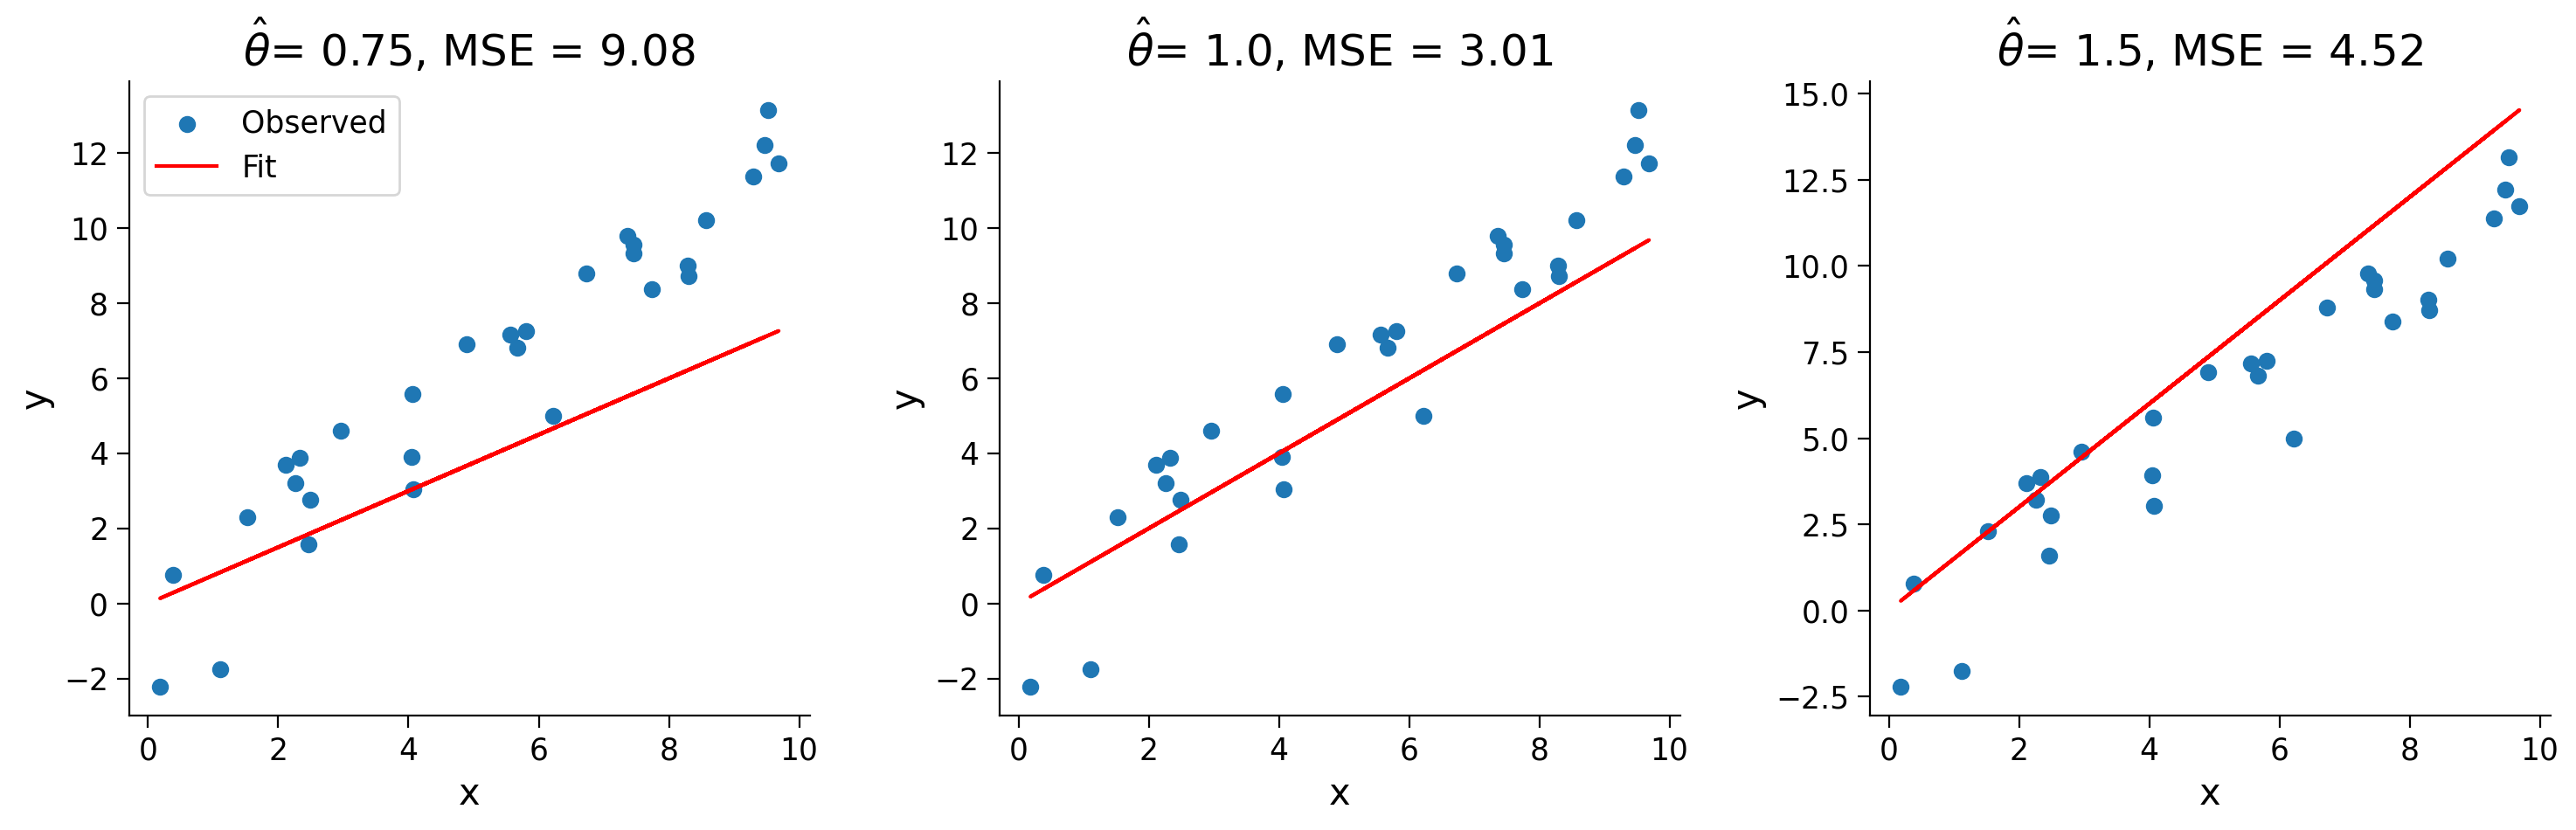

In [11]:
# Execute this cell to visualize estimated models

fig, axes = plt.subplots(ncols = 3, figsize = (15, 5))
for theta_hat, ax in zip(theta_hats, axes):

  # True data
  ax.scatter(x, y, label='Observed')  # our data scatter plot

  # Compute and plot predictions
  y_hat = theta_hat * x
  ax.plot(x, y_hat, color='r', label='Fit')  # our estimated model

  ax.set(
      title= fr'$\hat{{\theta}}$= {theta_hat}, MSE = {np.mean((y - y_hat)**2):.2f}',
      xlabel='x',
      ylabel='y'
  );

axes[0].legend()
plt.show() 

In [ ]:
# @markdown Make sure you execute this cell to enable the widget!
@widgets.interact(theta_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0))
def plot_data_estimate(theta_hat):
  y_hat = theta_hat * x
  plot_observed_vs_predicted(x, y, y_hat, theta_hat)

# manually chamging value of the Theta on the slider we see that Theta_hat = 1.2 results in the minimum MSE


interactive(children=(FloatSlider(value=1.0, description='theta_hat', max=2.0), Output()), _dom_classes=('widg…

In [15]:
# plot MSE as a function of the Theta-hat


### Tutorial 2: Linear regression with MLE
### Section 2.1: Maximum Likelihood Estimation
##### Here we will (1) code likelihood function for my gaussian distribution; and (2) Fit linear regression with MLE.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [26]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [27]:
# @title Plotting Functions
def plot_density_image(x, y, theta, sigma=1, ax=None):
  """ Plots probability distribution of y given x, theta, and sigma

  Args:

    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta (float): Slope parameter
    sigma (float): standard deviation of Gaussian noise

  """

  # plot the probability density of p(y|x,theta)
  if ax is None:
    fig, ax = plt.subplots()

  xmin, xmax = np.floor(np.min(x)), np.ceil(np.max(x))
  ymin, ymax = np.floor(np.min(y)), np.ceil(np.max(y))
  xx = np.linspace(xmin, xmax, 50)
  yy = np.linspace(ymin, ymax, 50)

  surface = np.zeros((len(yy), len(xx)))
  for i, x_i in enumerate(xx):
    surface[:, i] = stats.norm(theta * x_i, sigma).pdf(yy)

  ax.set(xlabel='x', ylabel='y')

  return ax.imshow(surface, origin='lower', aspect='auto', vmin=0, vmax=None,
            cmap=plt.get_cmap('Wistia'),
            extent=[xmin, xmax, ymin, ymax])

In [29]:
# Gaussian to have a model of our noise component as random variable

@widgets.interact(mu=widgets.FloatSlider(0.0, min=-2.0, max=2.0),
                  sigma=widgets.FloatSlider(1.0, min=0.5, max=2.0))
def plot_normal_dist(mu=0, sigma=1):

  # Generate pdf & samples from normal distribution with mu/sigma
  rv = stats.norm(mu, sigma)
  x = np.linspace(-5, 5, 100)
  y = rv.pdf(x)
  samples = rv.rvs(1000)

  # Plot
  fig, ax = plt.subplots()
  ax.hist(samples, 20, density=True, color='g', histtype='stepfilled',
          alpha=0.8, label='histogram')
  ax.plot(x, y, color='orange', linewidth=3, label='pdf')
  ax.vlines(mu, 0, rv.pdf(mu), color='y', linewidth=3, label='$\mu$')
  ax.vlines([mu-sigma, mu+sigma], 0, rv.pdf([mu-sigma, mu+sigma]), colors='red',
            color='b', linewidth=3, label='$\sigma$')
  ax.set(xlabel='x', ylabel='probability density', xlim=[-5, 5], ylim=[0, 1.0])
  ax.legend()
  plt.show()

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\huawei\AppData\Local\Temp\ipykernel_14808\2724223781.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax.vlines(mu, 0, rv.pdf(mu), color='y', linewidth=3, label='$\mu$')
C:\Users\huawei\AppData\Local\Temp\ipykernel_14808\2724223781.py:20: SyntaxWarning: invalid escape sequence '\s'
  color='b', linewidth=3, label='$\sigma$')


interactive(children=(FloatSlider(value=0.0, description='mu', max=2.0, min=-2.0), FloatSlider(value=1.0, desc…

### Section 2.2: Probabilistic models


In [ ]:
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence

np.random.seed(121)
theta = 1.2
n_samples = 30
x = 10 * np.random.rand(n_samples) # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y = theta * x + noise

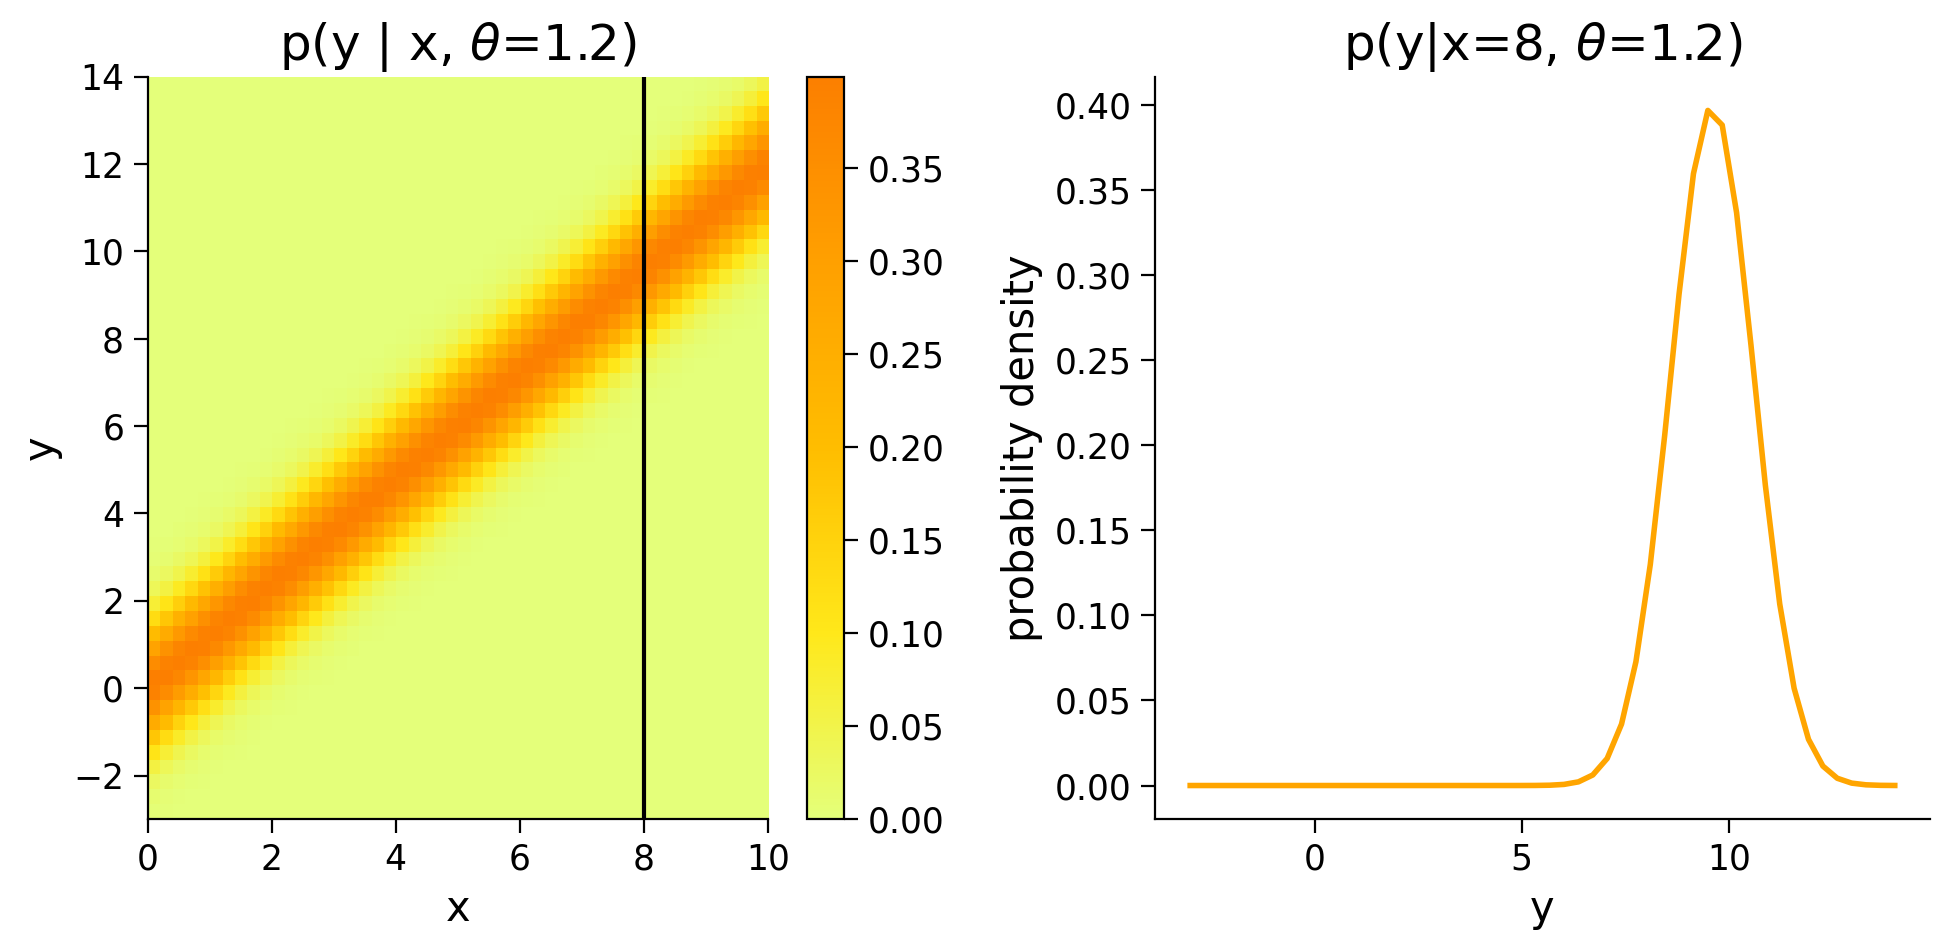

In [31]:
# Execute this cell to visualize p(y|x, theta=1.2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Invokes helper function to generate density image plots from data and parameters
im = plot_density_image(x, y, 1.2, ax=ax1)
plt.colorbar(im, ax=ax1)
ax1.axvline(8, color='k')
ax1.set(title=r'p(y | x, $\theta$=1.2)')

# Plot pdf for given x
ylim = ax1.get_ylim()
yy = np.linspace(ylim[0], ylim[1], 50)
ax2.plot(yy, stats.norm(theta * 8, 1).pdf(yy), color='orange', linewidth=2)
ax2.set(
    title=r'p(y|x=8, $\theta$=1.2)',
    xlabel='y',
    ylabel='probability density')
plt.show()

In [34]:
# implement the likelihood function
def likelihood(theta_hat, x, y):
  """The likelihood function for a linear model with noise sampled from a
    Gaussian distribution with zero mean and unit variance.

  Args:
    theta_hat (float): An estimate of the slope parameter.
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray: the likelihood values for the theta_hat estimate
  """
  sigma = 1

  # Compute Gaussian likelihood
  pdf = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(y - theta_hat * x)**2 / (2 * sigma**2))

  return pdf


print(likelihood(1.0, x[1], y[1]))

0.11344443599846923


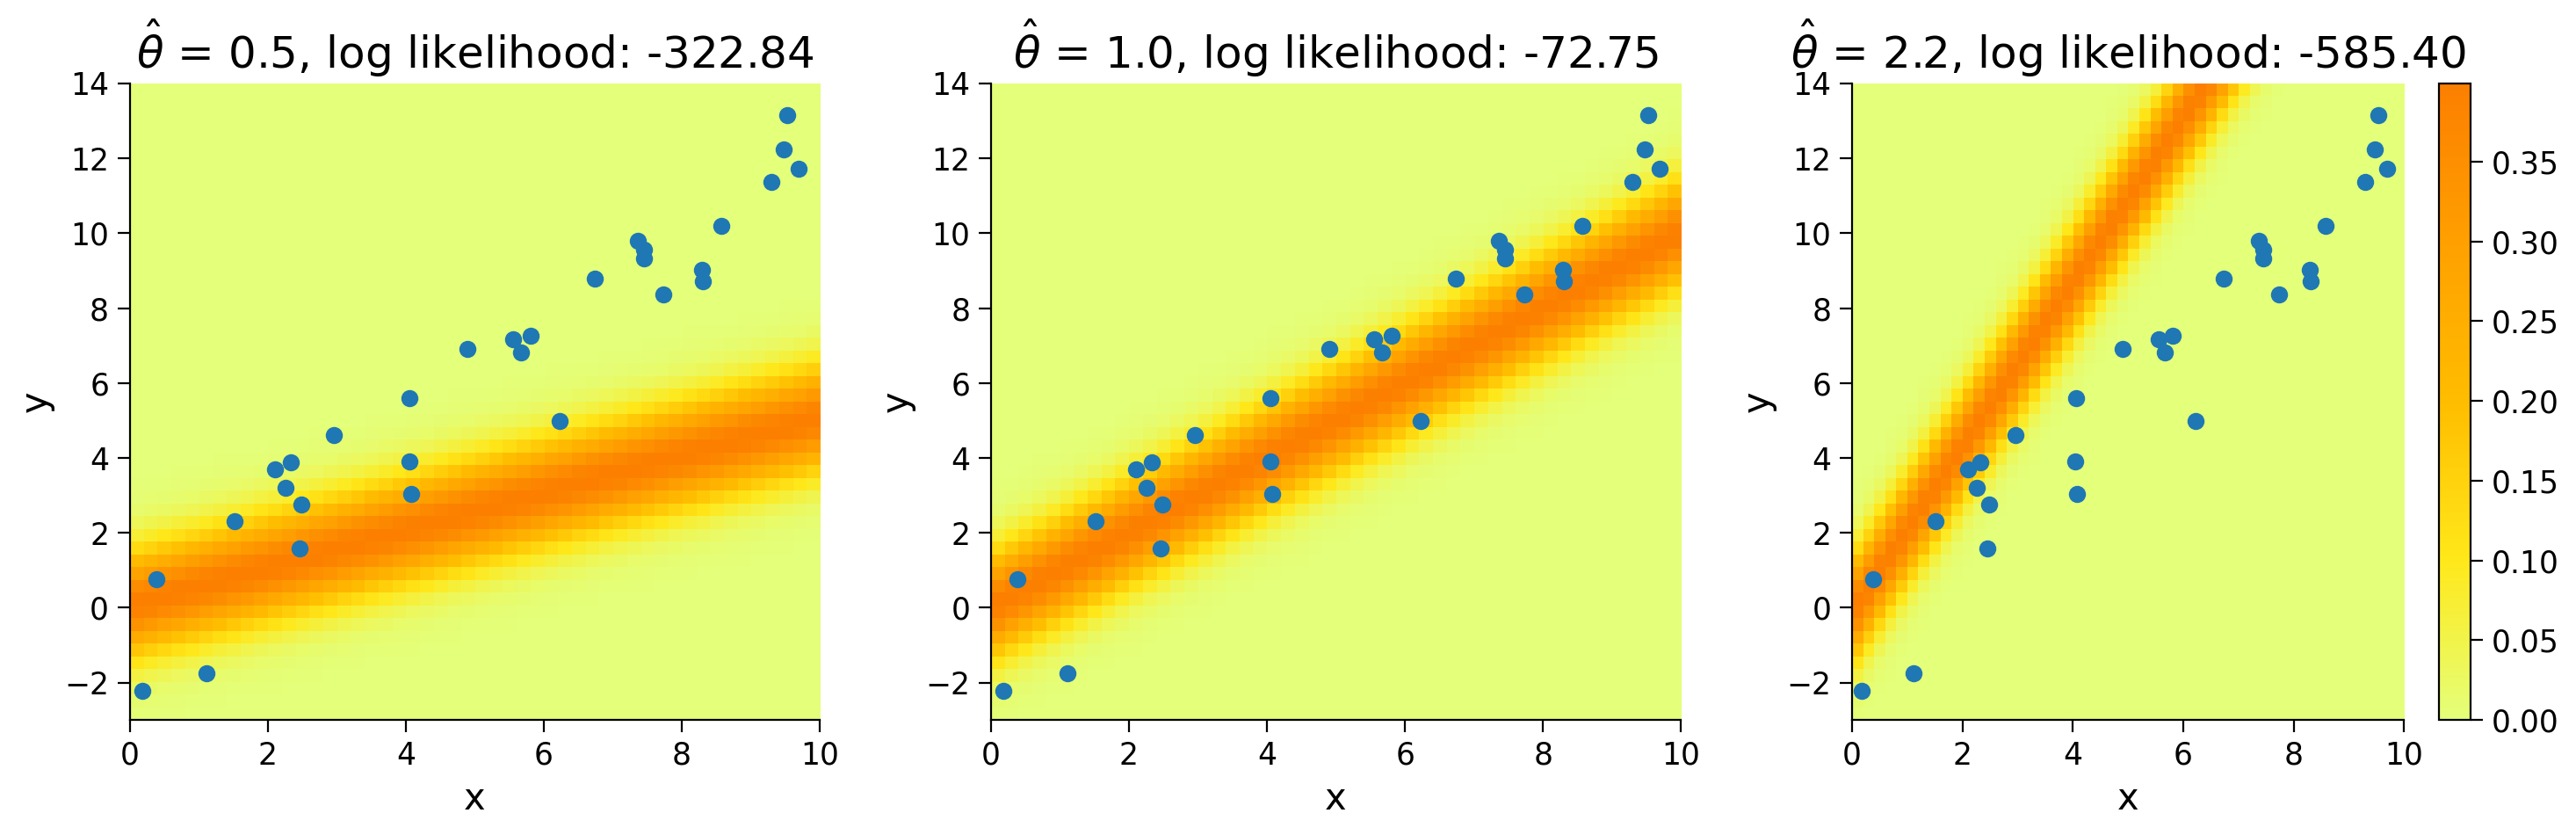

In [37]:
# how does this tell us how this estimate is better than any others?
# visualize different distribution densities
theta_hats = [0.5, 1.0, 2.2]
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for theta_hat, ax in zip(theta_hats, axes):
  ll = np.sum(np.log(likelihood(theta_hat, x, y)))  # log likelihood
  im = plot_density_image(x, y, theta_hat, ax=ax)
  ax.scatter(x, y)
  ax.set(title=fr'$\hat{{\theta}}$ = {theta_hat}, log likelihood: {ll:.2f}')
plt.colorbar(im, ax=ax)
plt.show()

In [38]:
# dot products
# Compute theta_hat_MLE
theta_hat_mle = (x @ y) / (x @ x)

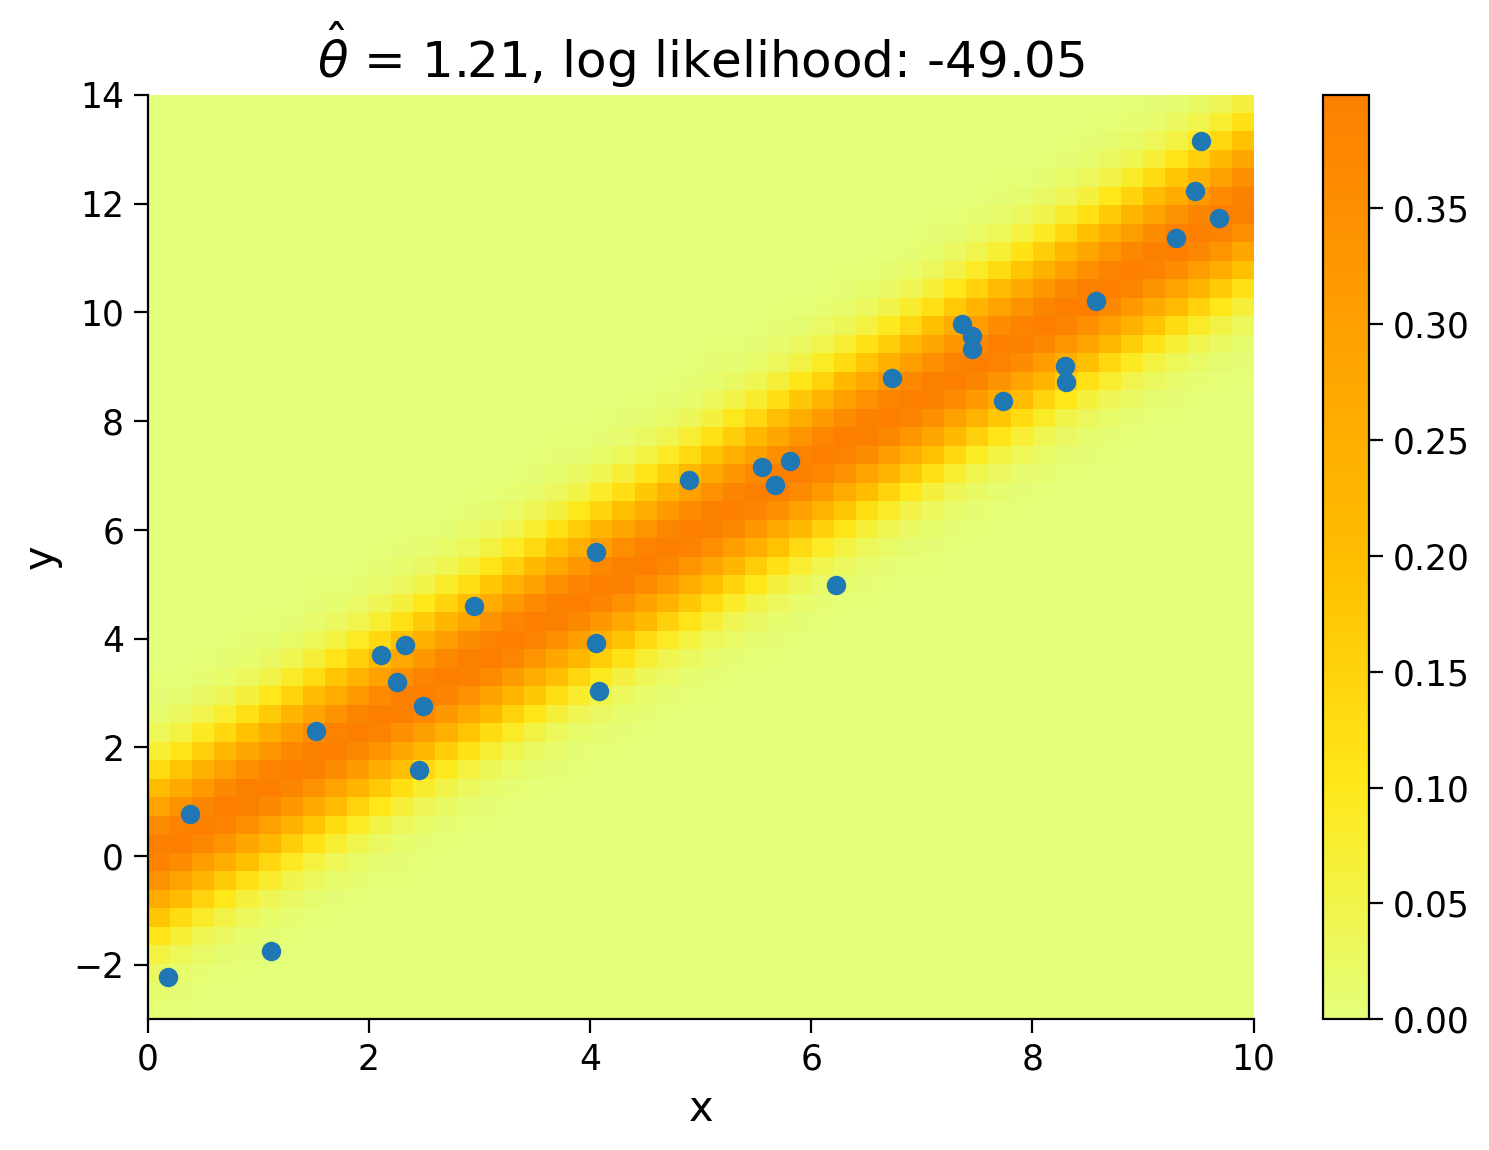

In [41]:
# Plot the resulting distribution density
fig, ax = plt.subplots()
ll = np.sum(np.log(likelihood(theta_hat_mle, x, y))) # log likelihood
im = plot_density_image(x, y, theta_hat_mle, ax=ax)
plt.colorbar(im, ax=ax)
ax.scatter(x, y)
ax.set(title=fr'$\hat{{\theta}}$ = {theta_hat_mle:.2f}, log likelihood: {ll:.2f}')
plt.show()

### Section 3: Confidence interval and bootstrapping 
##### We will use bootstrapping to build confidence intervals around the inferred linear model parameters

In [42]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [46]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [47]:
def plot_original_and_resample(x, y, x_, y_):
  """ Plot the original sample and the resampled points from this sample.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    x_ (ndarray): An array of shape (samples,) with a subset of input values from x
    y_ (ndarray): An array of shape (samples,) with a the corresponding subset
      of measurement values as x_ from y

  """
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  ax1.scatter(x, y)
  ax1.set(title='Original', xlabel='x', ylabel='y')

  ax2.scatter(x_, y_, color='c')

  ax2.set(title='Resampled', xlabel='x', ylabel='y',
          xlim=ax1.get_xlim(), ylim=ax1.get_ylim())
  plt.show()

In [49]:
def plot_original_and_resample(x, y, x_, y_):
  """ Plot the original sample and the resampled points from this sample.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    x_ (ndarray): An array of shape (samples,) with a subset of input values from x
    y_ (ndarray): An array of shape (samples,) with a the corresponding subset
      of measurement values as x_ from y

  """
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  ax1.scatter(x, y)
  ax1.set(title='Original', xlabel='x', ylabel='y')

  ax2.scatter(x_, y_, color='c')

  ax2.set(title='Resampled', xlabel='x', ylabel='y',
          xlim=ax1.get_xlim(), ylim=ax1.get_ylim())
  plt.show()

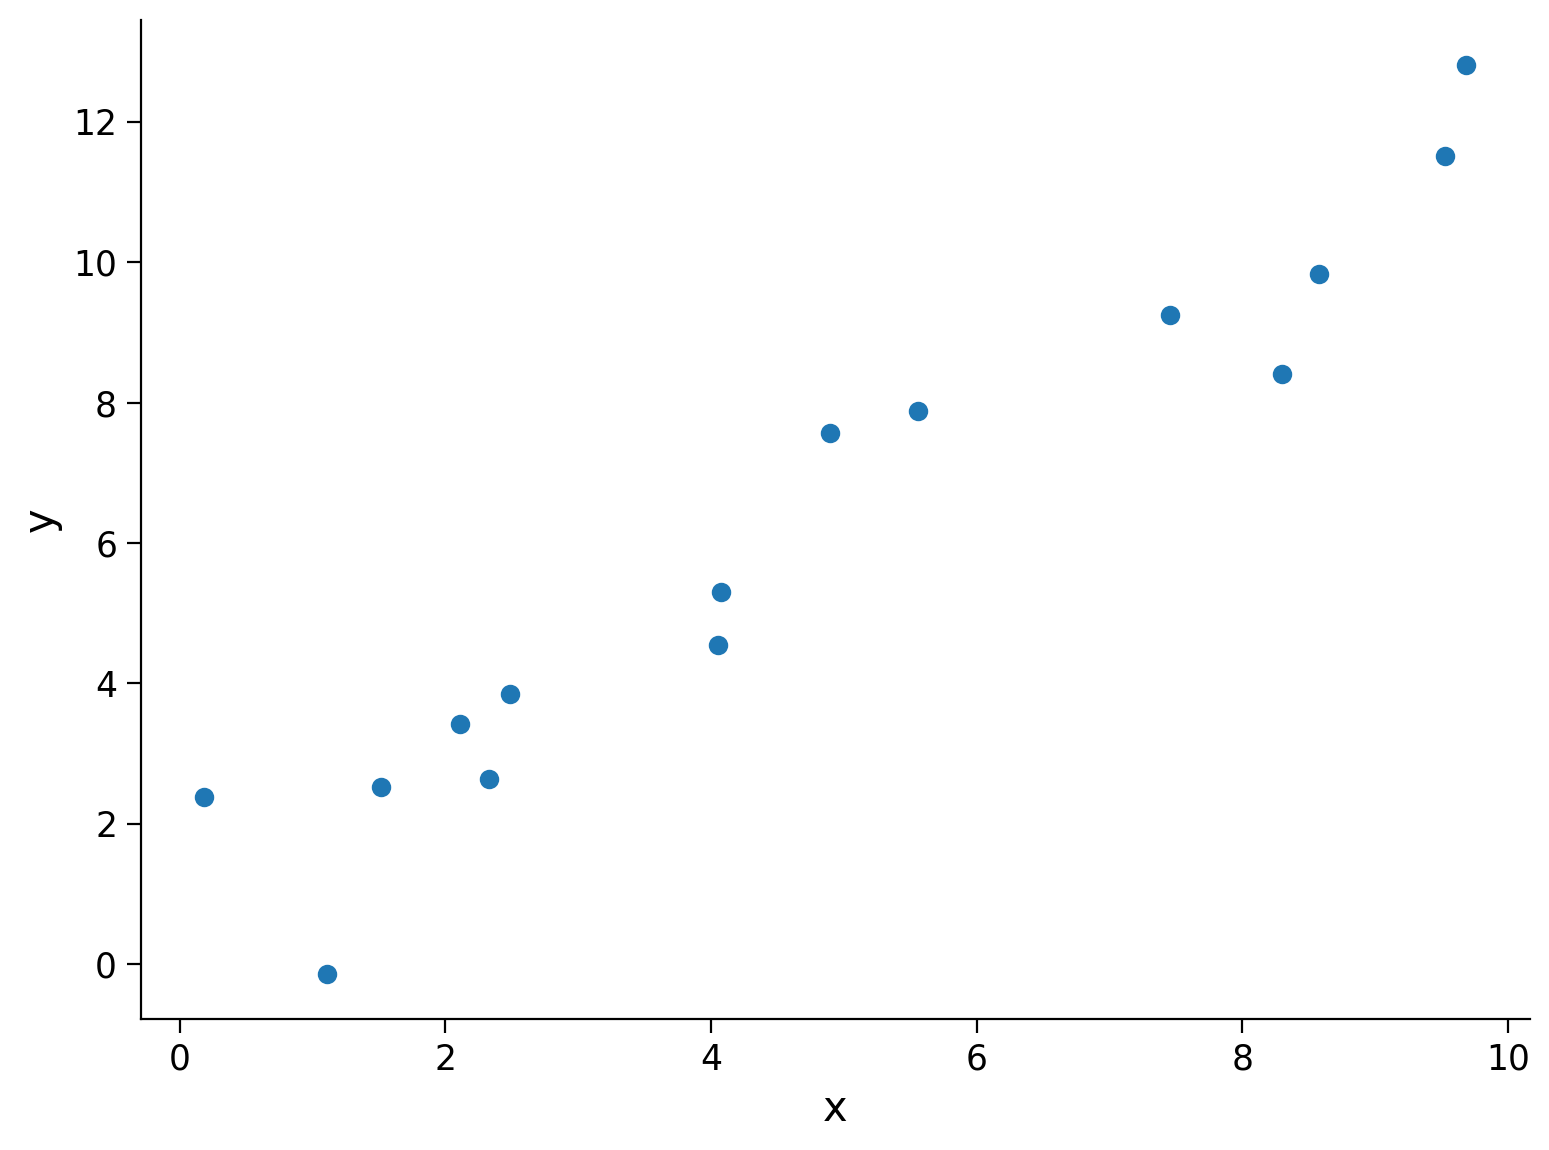

In [60]:
# start again with our noisy samples along the line , but this time, we only use half the data points as last time (15 instead of 30).
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 15

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution in [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

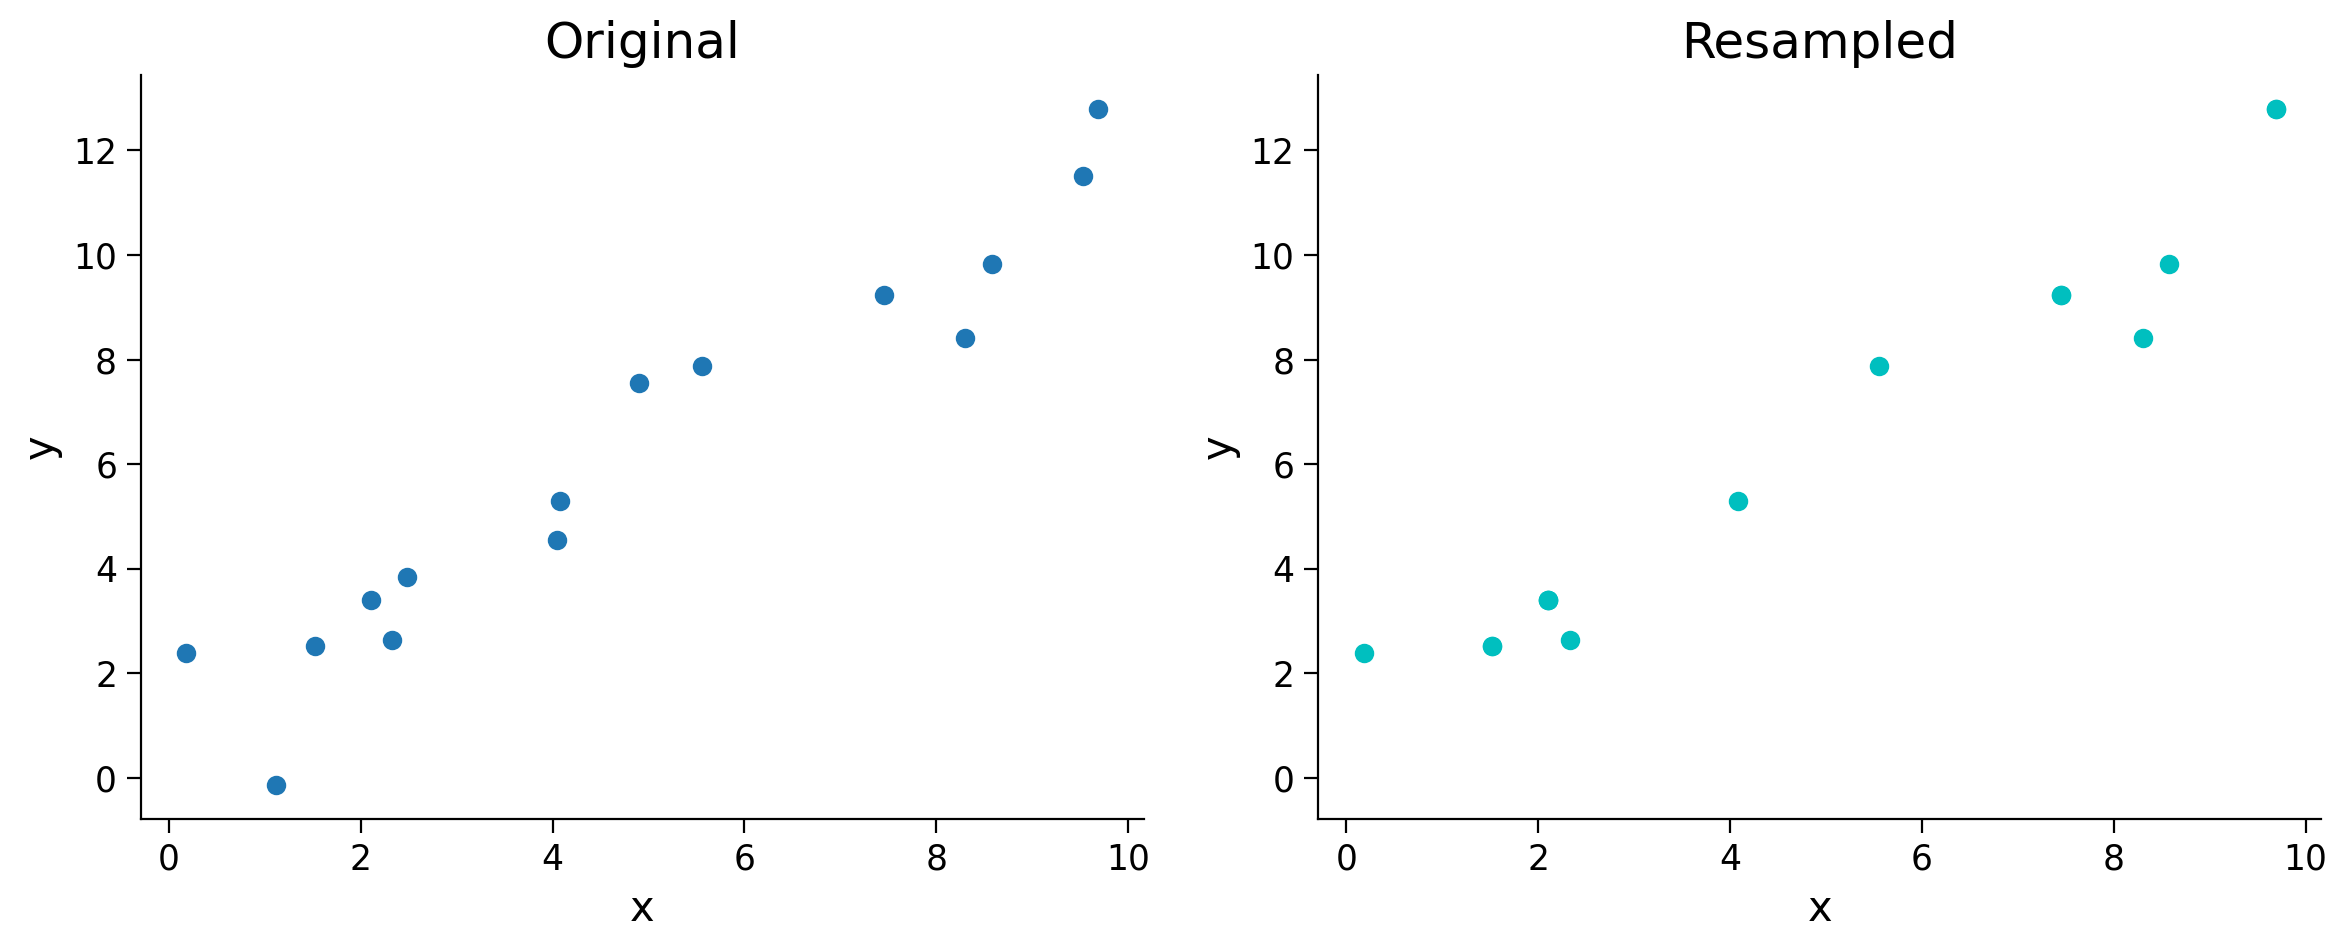

In [ ]:
# Resample Dataset with Replacement
def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """
  
  # Get array of indices for resampled points
  sample_idx = np.random.choice(len(x), size=len(x), replace=True)

  # Sample from x and y according to sample_idx
  x_ = x[sample_idx]
  y_ = y[sample_idx]

  return x_, y_

x_, y_ = resample_with_replacement(x, y)

plot_original_and_resample(x, y, x_, y_)

In [62]:
# for helper function `solve_normal_eqn`
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    thata_hat (float): An estimate of the slope parameter.

  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """
  theta_hat = (x.T @ y) / (x.T @ x)
  return theta_hat

In [67]:
def bootstrap_estimates(x, y, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute

  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros(n)

  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = resample_with_replacement(x, y)

    # Compute theta_hat for this sample
    theta_hats[i] = (x_.T @ y_) / (x_.T @ x_)

  return theta_hats


# Set random seed
np.random.seed(123)

# Get bootstrap estimates
theta_hats = bootstrap_estimates(x, y, n=2000)
print(theta_hats[0:5])

[1.27550888 1.17317819 1.18198819 1.25329255 1.20714664]


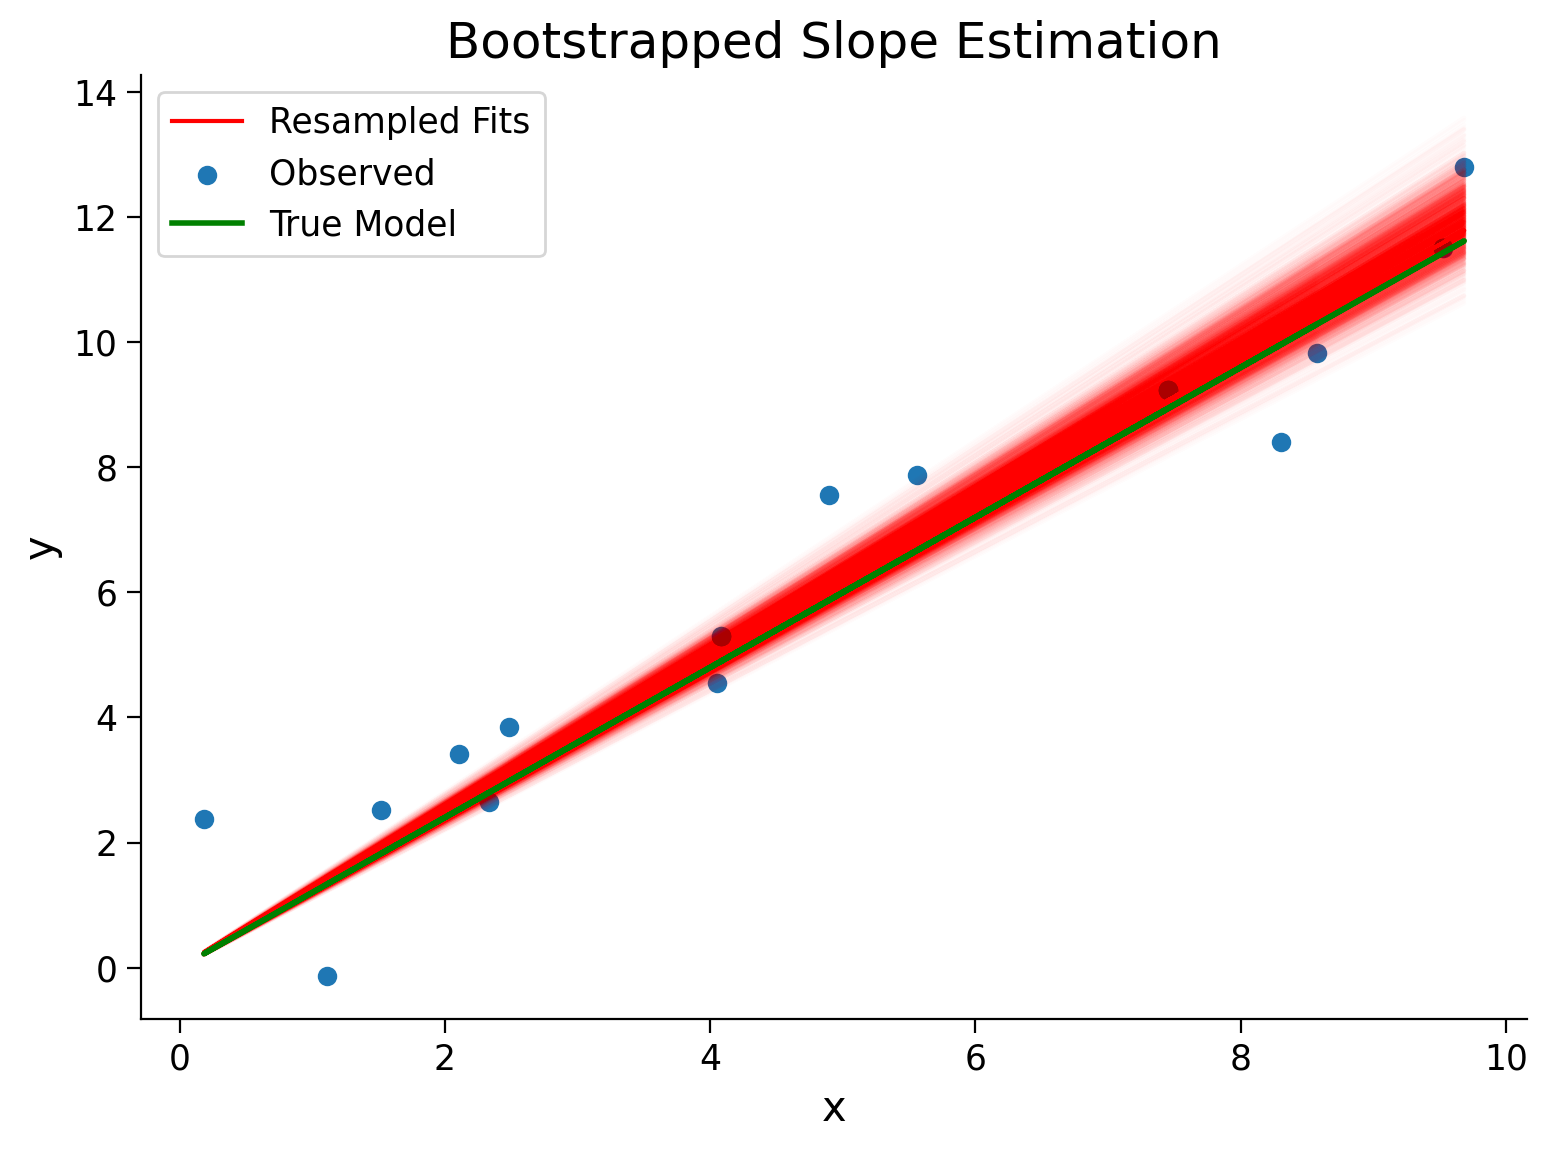

In [68]:
# @markdown Execute this cell to visualize all potential models

fig, ax = plt.subplots()

# For each theta_hat, plot model
theta_hats = bootstrap_estimates(x, y, n=2000)
for i, theta_hat in enumerate(theta_hats):
  y_hat = theta_hat * x
  ax.plot(x, y_hat, c='r', alpha=0.01, label='Resampled Fits' if i==0 else '')

# Plot observed data
ax.scatter(x, y, label='Observed')

# Plot true fit data
y_true = theta * x
ax.plot(x, y_true, 'g', linewidth=2, label='True Model')

ax.set(
  title='Bootstrapped Slope Estimation',
  xlabel='x',
  ylabel='y'
)

# Change legend line alpha property
handles, labels = ax.get_legend_handles_labels()
handles[0].set_alpha(1)

ax.legend()
plt.show()

mean = 1.24, std = 0.05


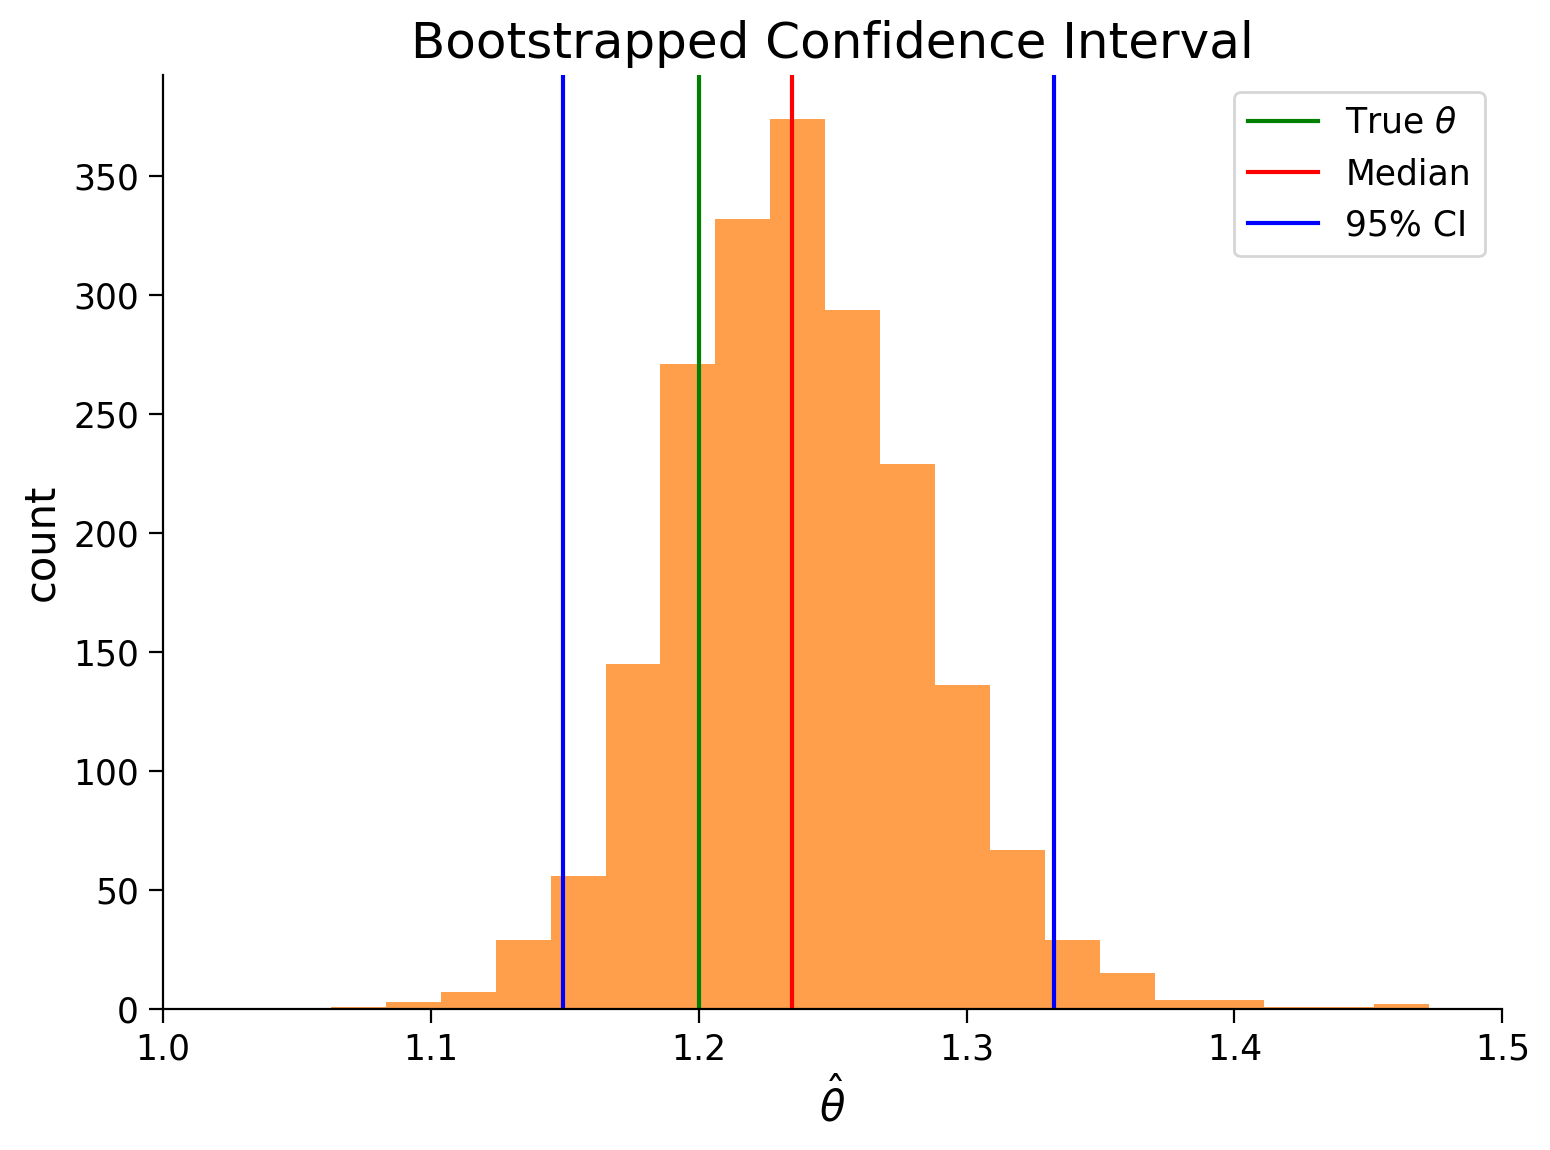

In [69]:
# how certain we are in this interval 

theta_hats = bootstrap_estimates(x, y, n=2000)
print(f"mean = {np.mean(theta_hats):.2f}, std = {np.std(theta_hats):.2f}")

fig, ax = plt.subplots()
ax.hist(theta_hats, bins=20, facecolor='C1', alpha=0.75)
ax.axvline(theta, c='g', label=r'True $\theta$')
ax.axvline(np.percentile(theta_hats, 50), color='r', label='Median')
ax.axvline(np.percentile(theta_hats, 2.5), color='b', label='95% CI')
ax.axvline(np.percentile(theta_hats, 97.5), color='b')
ax.legend()
ax.set(
    title='Bootstrapped Confidence Interval',
    xlabel=r'$\hat{{\theta}}$',
    ylabel='count',
    xlim=[1.0, 1.5]
)
plt.show()

### Tutorial 4: Multiple linear regression and polynomial regression
##### In this tutorial, we will generalize the regression model to incorporate multiple features; Learn how to structure inputs for regression using the ‘Design Matrix’; Generalize the MSE for multiple features using the ordinary least squares estimator; Visualize data and model fit in multiple dimensions; Fit polynomial regression models of different complexity; Plot and evaluate the polynomial regression fits

In [70]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [72]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Plotting Functions

def evaluate_fits(order_list, mse_list):
  """ Compare the quality of multiple polynomial fits
  by plotting their MSE values.

  Args:
    order_list (list): list of the order of polynomials to be compared
    mse_list (list): list of the MSE values for the corresponding polynomial fit
  """
  fig, ax = plt.subplots()
  ax.bar(order_list, mse_list)
  ax.set(title='Comparing Polynomial Fits', xlabel='Polynomial order', ylabel='MSE')
  plt.show()


def plot_fitted_polynomials(x, y, theta_hat):
  """ Plot polynomials of different orders

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    theta_hat (dict): polynomial regression weights for different orders
  """

  x_grid = np.linspace(x.min() - .5, x.max() + .5)

  plt.figure()

  for order in range(0, max_order + 1):
    X_design = make_design_matrix(x_grid, order)
    plt.plot(x_grid, X_design @ theta_hat[order]);

  plt.ylabel('y')
  plt.xlabel('x')
  plt.plot(x, y, 'C0.');
  plt.legend([f'order {o}' for o in range(max_order + 1)], loc=1)
  plt.title('polynomial fits')
  plt.show()

### Section 4.1: Multiple Linear Regression

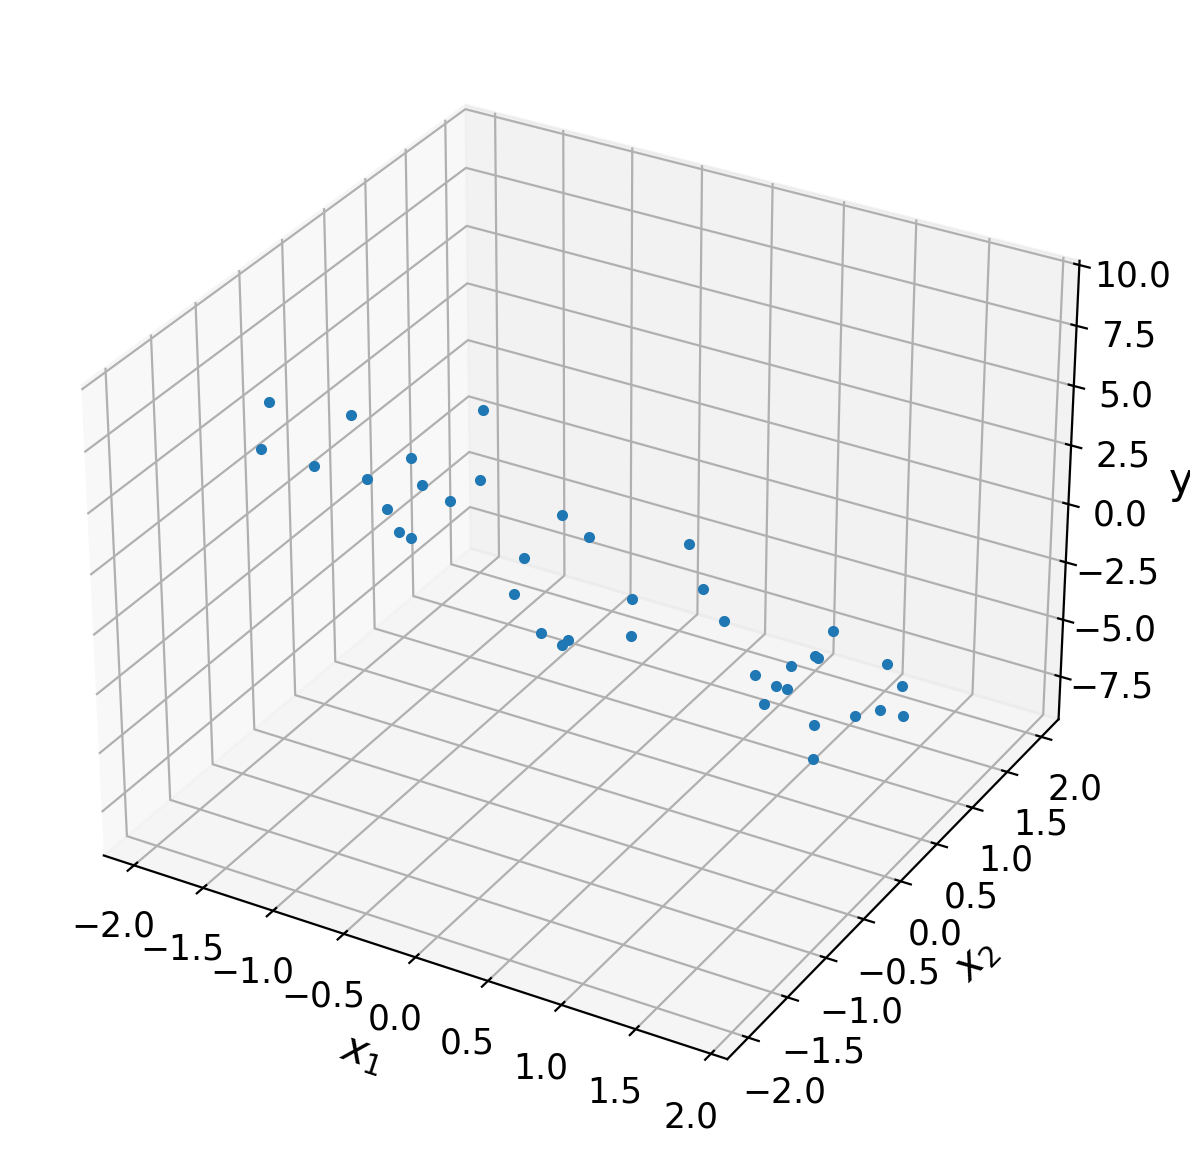

In [81]:
# Set random seed for reproducibility
np.random.seed(1234)

# Set parameters
theta = [0, -2, -3]
n_samples = 40

# Draw x and calculate y
n_regressors = len(theta)
x0 = np.ones((n_samples, 1))
x1 = np.random.uniform(-2, 2, (n_samples, 1))
x2 = np.random.uniform(-2, 2, (n_samples, 1))
X = np.hstack((x0, x1, x2))
noise = np.random.randn(n_samples)
y = X @ theta + noise


ax = plt.subplot(projection='3d')
ax.plot(X[:,1], X[:,2], y, '.')

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout()

In [84]:
def ordinary_least_squares(X, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """


  # Compute theta_hat using OLS
  theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

  return theta_hat


theta_hat = ordinary_least_squares(X, y)
print(theta_hat)

[ 0.13861386 -2.09395731 -3.16370742]


In [87]:
# Compute predicted data
theta_hat = ordinary_least_squares(X, y)
y_hat = X @ theta_hat

# Compute MSE
print(f"MSE = {np.mean((y - y_hat)**2):.2f}")

MSE = 0.91


### Section 4.2: Polynomial Regression 
##### is an extension of linear regression.

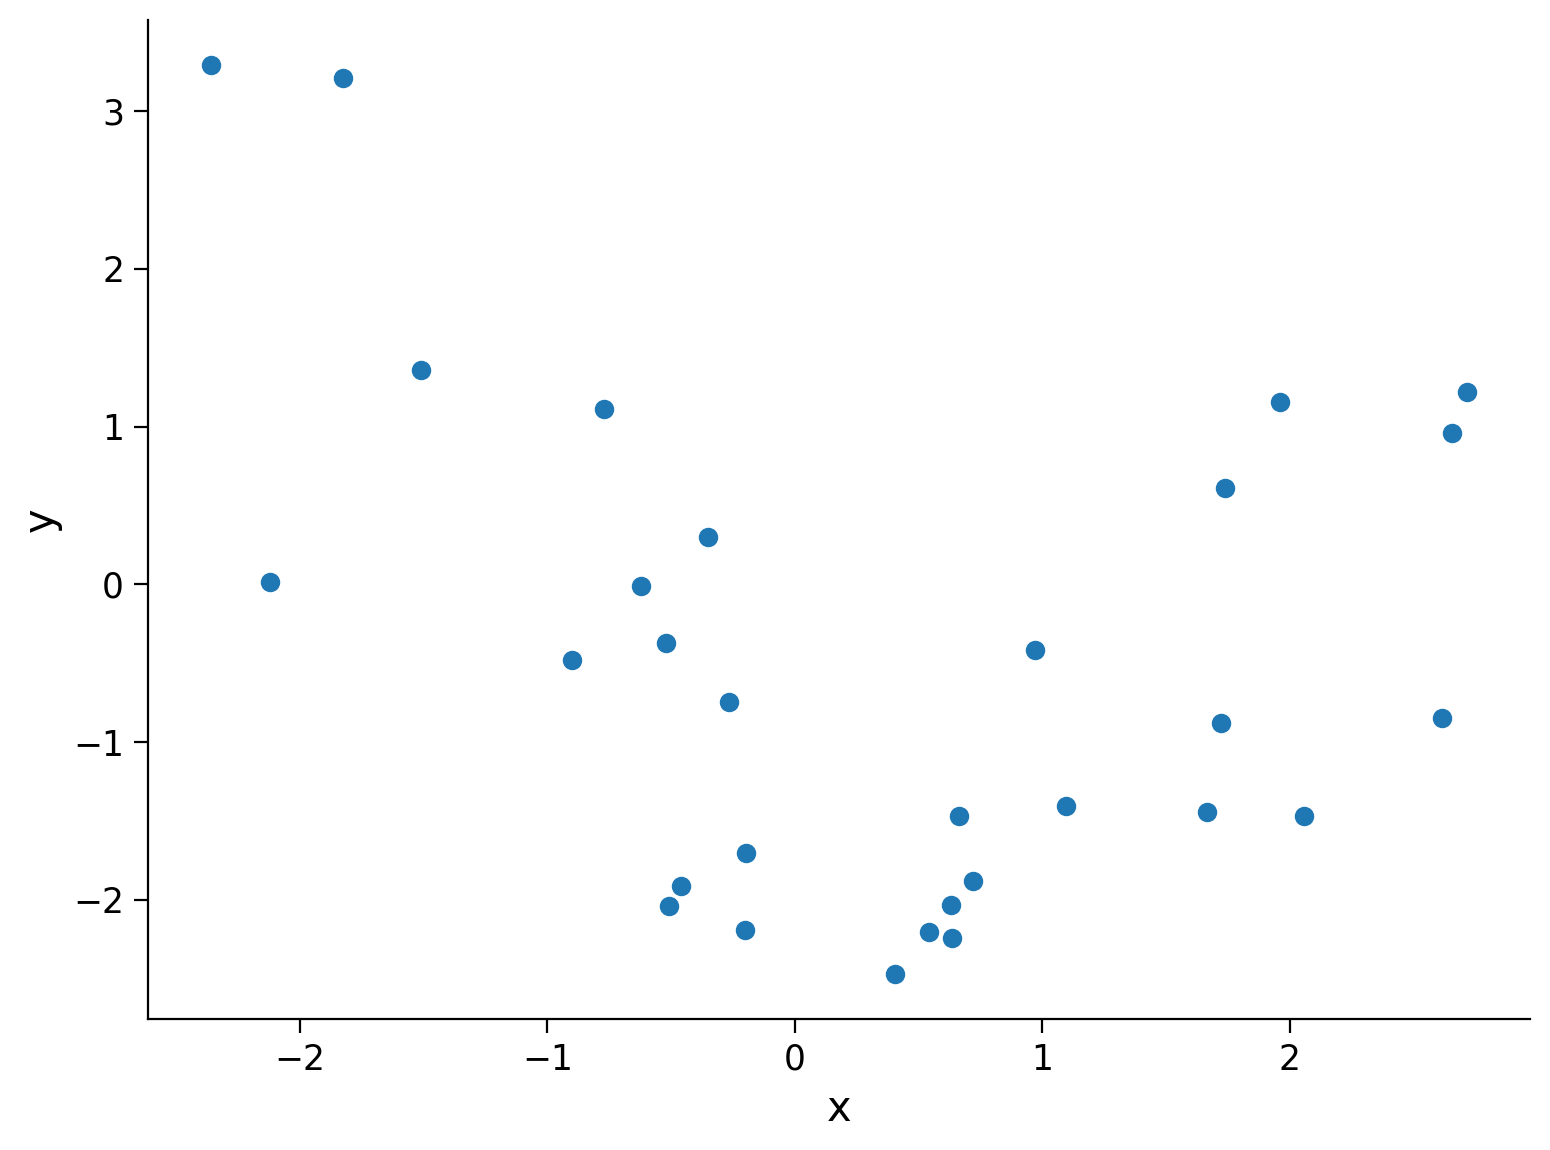

In [90]:
# simulation of some data to practice fitting polynomial regression models

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)
n_samples = 30
x = np.random.uniform(-2, 2.5, n_samples)  # inputs uniformly sampled from [-2, 2.5)
y =  x**2 - x - 2                          # computing the outputs

output_noise = 1/8 * np.random.randn(n_samples)
y += output_noise                          # adding some output noise

input_noise = 1/2 * np.random.randn(n_samples)
x += input_noise                           # adding some input noise

fig, ax = plt.subplots()
ax.scatter(x, y)                           # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

### Section 4.2.1: Create the design matrix of inputs for use in polynomial regression

In [ ]:
# Create the design matrix of inputs for use in polynomial regression
def make_design_matrix(x, order):
  """
  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """
  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns (hint: np.hstack)
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


order = 5
X_design = make_design_matrix(x, order)

print(X_design[0:2, 0:2])

[[ 1.         -1.51194917]
 [ 1.         -0.35259945]]


### Section 4.2.2: Fitting polynomial regression models

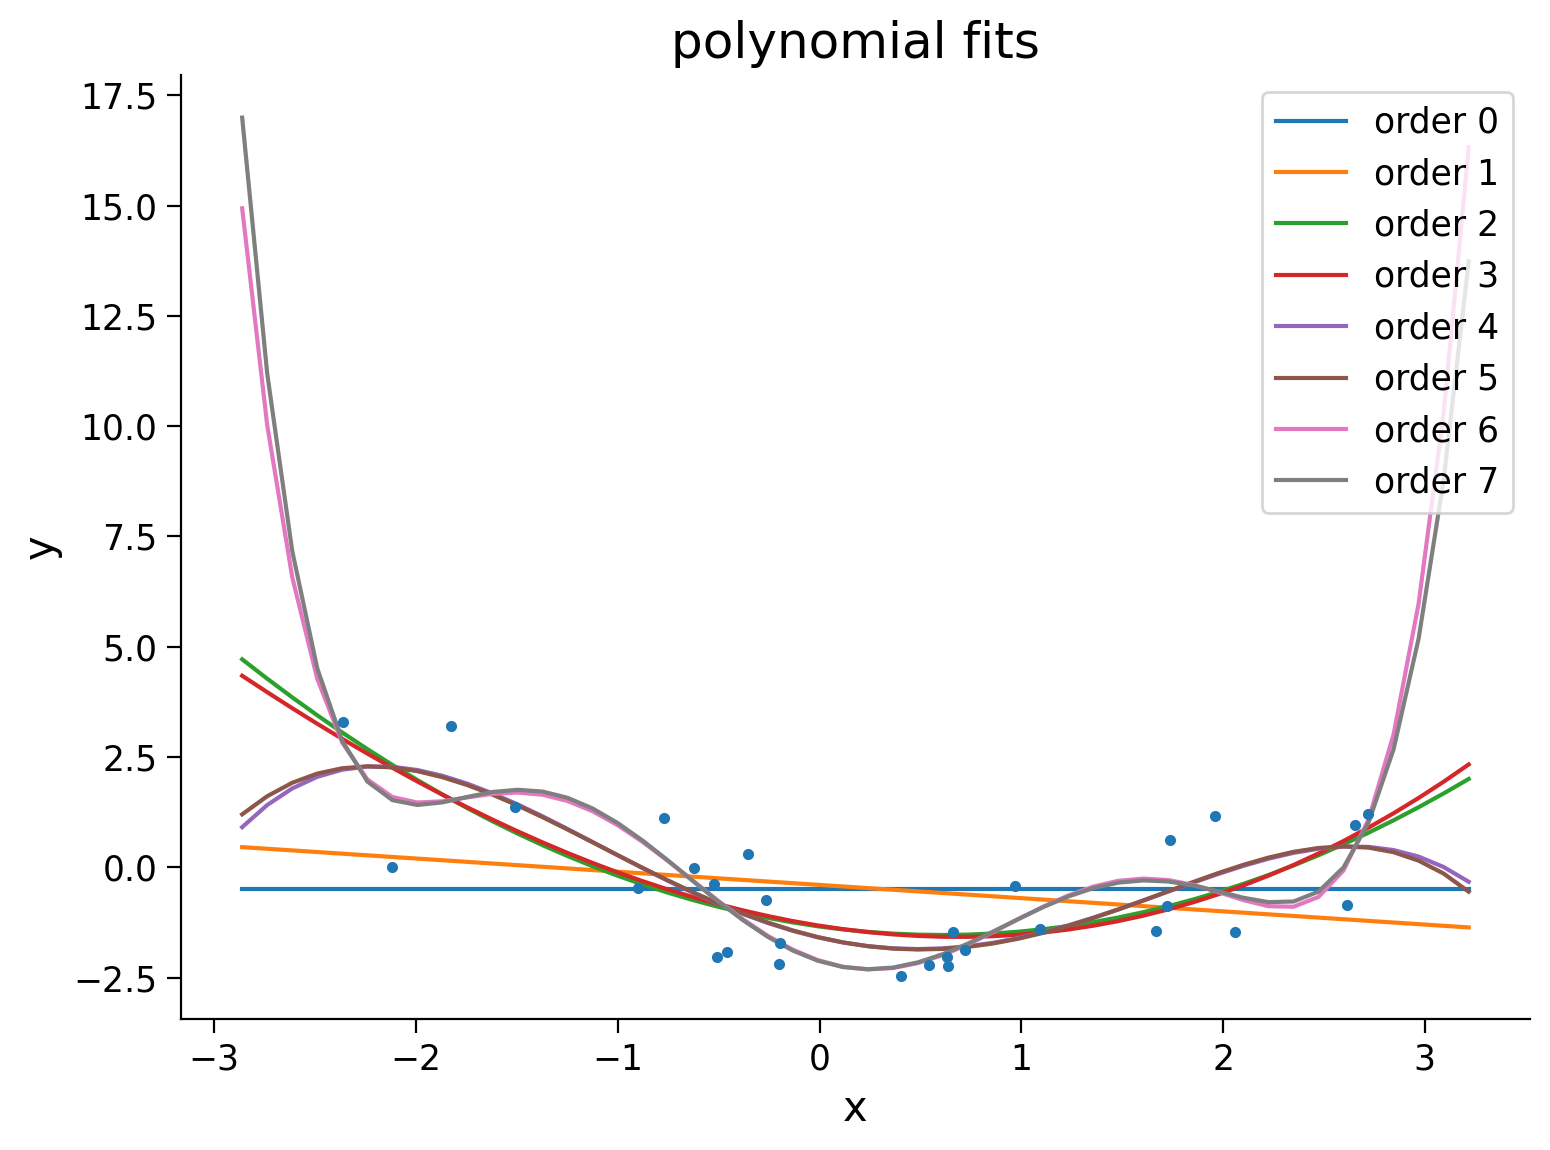

In [124]:
# Fitting polynomial regression models for each order 0 through max_order.
def solve_poly_reg(x, y, max_order):
  """
  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys,
  # and np array of theta_hat (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    # Create design matrix
    X_design = make_design_matrix(x, order)

    # Fit polynomial model
    this_theta = np.linalg.inv(X_design.T @ X_design) @ X_design.T @ y
  # this_theta = ordinary_least_squares(X_design, y)
  
    theta_hats[order] = this_theta

  return theta_hats


max_order = 7 # 18 is the best option in terms of the lowest MSE
theta_hats = solve_poly_reg(x, y, max_order)

# Visualize
plot_fitted_polynomials(x, y, theta_hats)

### Section 4.2.3: Evaluating fit quality

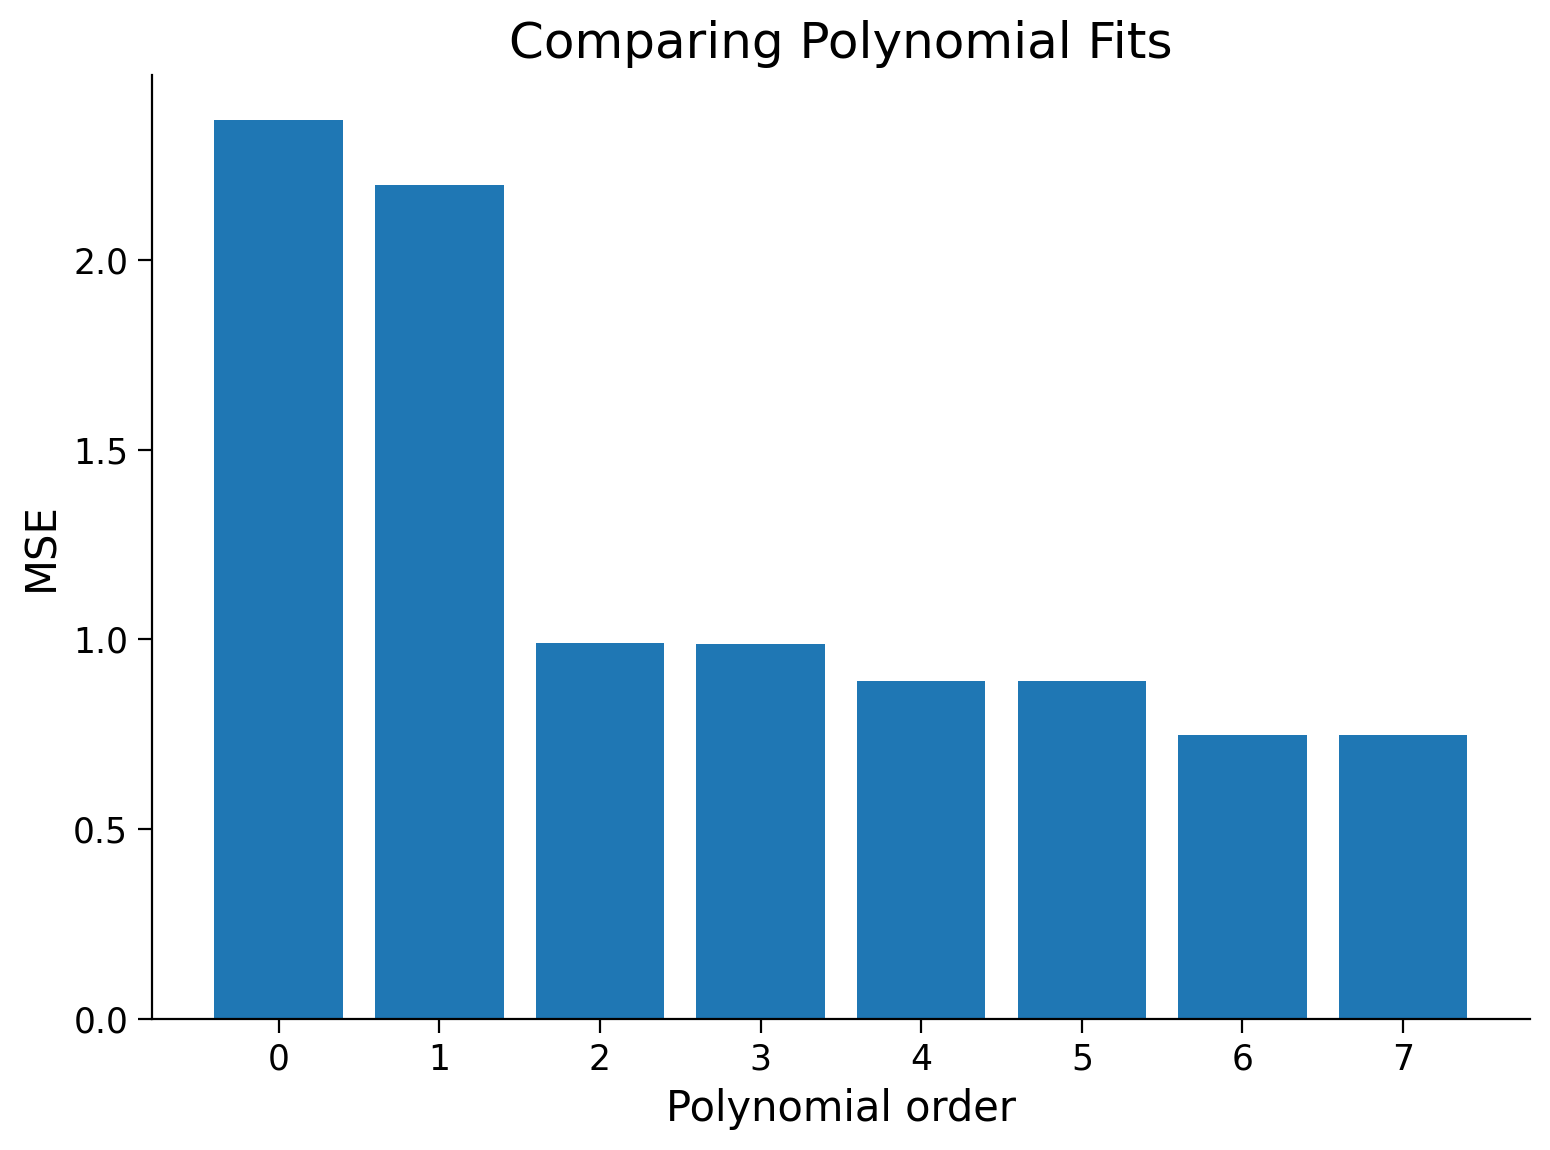

In [125]:
# Evaluating fit quality by comparing the MSE 
# for different polynomial orders with a bar plot.
mse_list = []
order_list = list(range(max_order + 1))

for order in order_list:

  X_design = make_design_matrix(x, order)

  # Get prediction for the polynomial regression model of this order
  y_hat = X_design @ theta_hats[order]

  # Compute the residuals
  residuals = y-y_hat

  # Compute the MSE
  mse = np.mean(residuals**2)

  mse_list.append(mse)


# Visualize MSE of fits
evaluate_fits(order_list, mse_list)



### Tutorial 5: Model Selection: Bias-variance trade-off
##### Here we will understand difference between test and train data; Compare train and test error for models of varying complexity; Understand how bias-variance tradeoff relates to what model we choose

In [126]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Plotting Functions

def plot_MSE_poly_fits(mse_train, mse_test, max_order):

  fig, ax = plt.subplots()
  width = .35

  ax.bar(np.arange(max_order + 1) - width / 2,
         mse_train, width, label="train MSE")
  ax.bar(np.arange(max_order + 1) + width / 2,
         mse_test , width, label="test MSE")

  ax.legend()
  ax.set(xlabel='Polynomial order', ylabel='MSE',
         title='Comparing polynomial fits')
  plt.show()

In [134]:
def evaluate_poly_reg(x, y, theta_hats, max_order):
  
  mse = np.zeros((max_order + 1))
  for order in range(0, max_order + 1):
    X_design = make_design_matrix(x, order)
    y_hat = np.dot(X_design, theta_hats[order])
    residuals = y - y_hat
    mse[order] = np.mean(residuals ** 2)

  return mse

In [135]:
# Helper functions what was above

def ordinary_least_squares(x, y):
  """
    Ordinary least squares estimator for linear regression.
    Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  return np.linalg.inv(x.T @ x) @ x.T @ y


def make_design_matrix(x, order):
  """
  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """

  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0],1))

  # Loop through rest of degrees and stack columns
  for degree in range(1, order+1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix

def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.
  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits
  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order+1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hats[order] = this_theta

  return theta_hats

### Section 5.1: Train vs test data

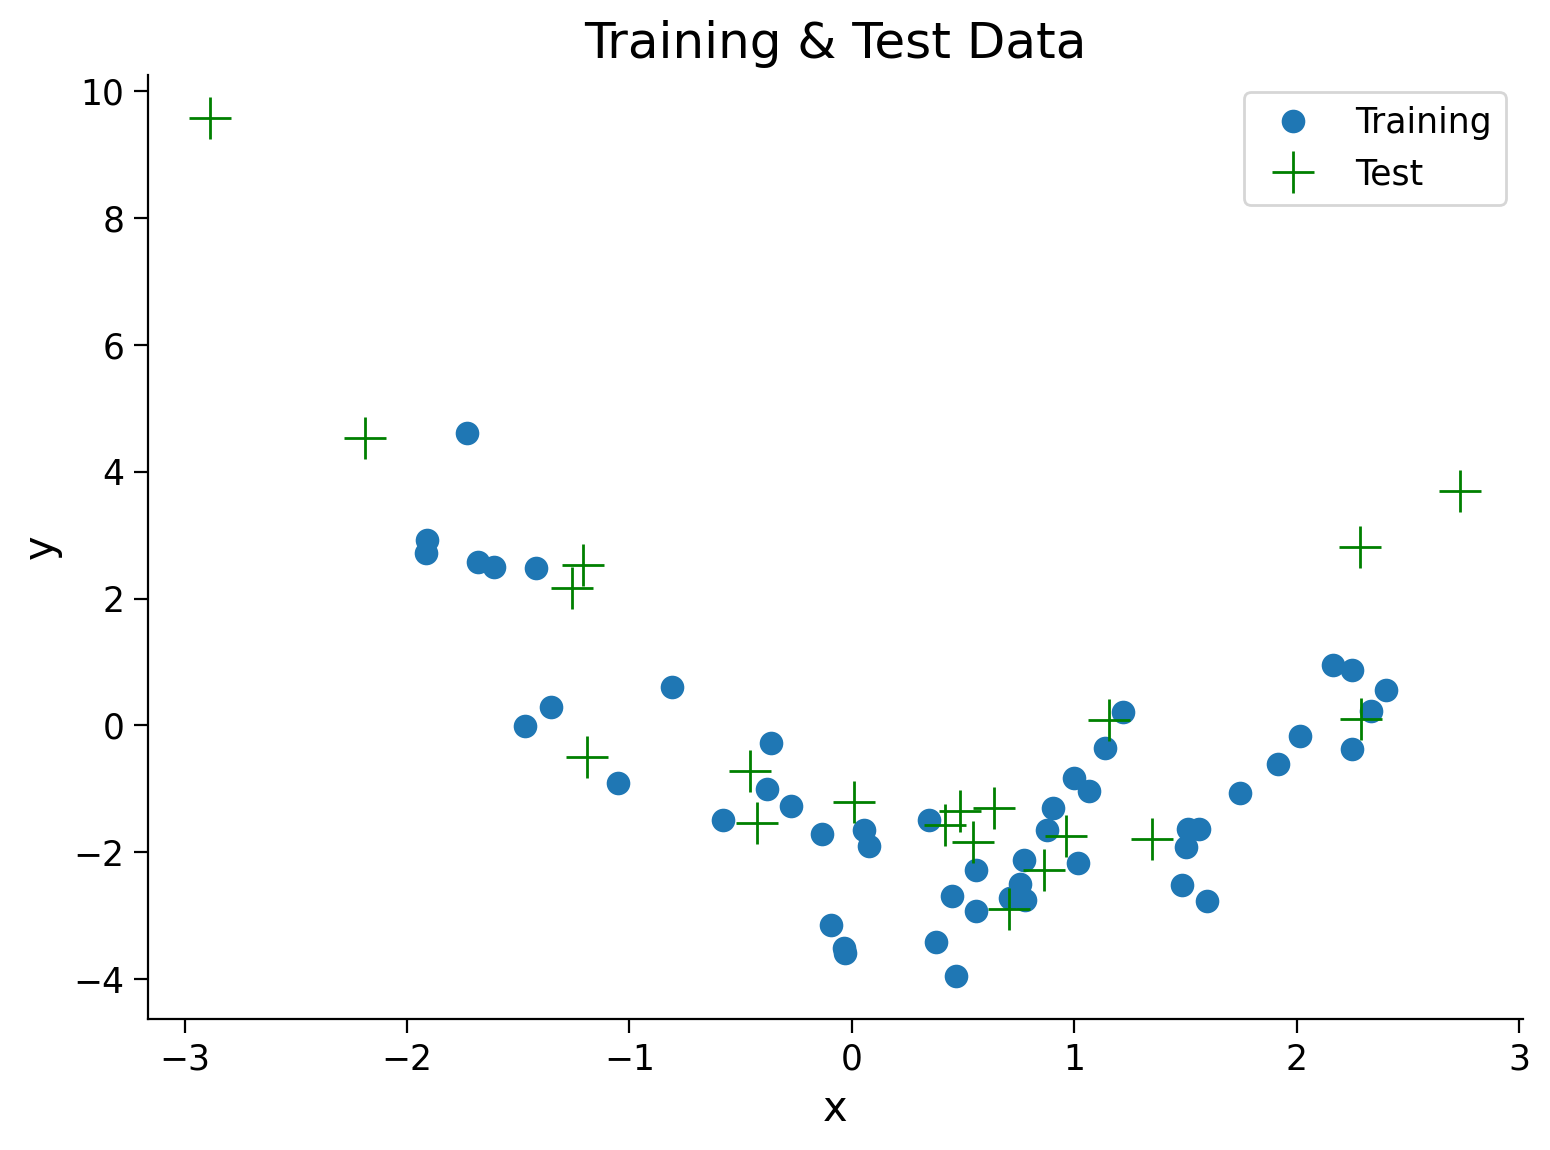

In [138]:
### Generate training data
np.random.seed(0)
n_train_samples = 50
x_train = np.random.uniform(-2, 2.5, n_train_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_train_samples) # sample from a standard normal distribution
y_train =  x_train**2 - x_train - 2 + noise

### Generate testing data
n_test_samples = 20
x_test = np.random.uniform(-3, 3, n_test_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_test_samples) # sample from a standard normal distribution
y_test =  x_test**2 - x_test - 2 + noise

## Plot both train and test data
fig, ax = plt.subplots()
plt.title('Training & Test Data')
plt.plot(x_train, y_train, '.', markersize=15, label='Training')
plt.plot(x_test, y_test, 'g+', markersize=15, label='Test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

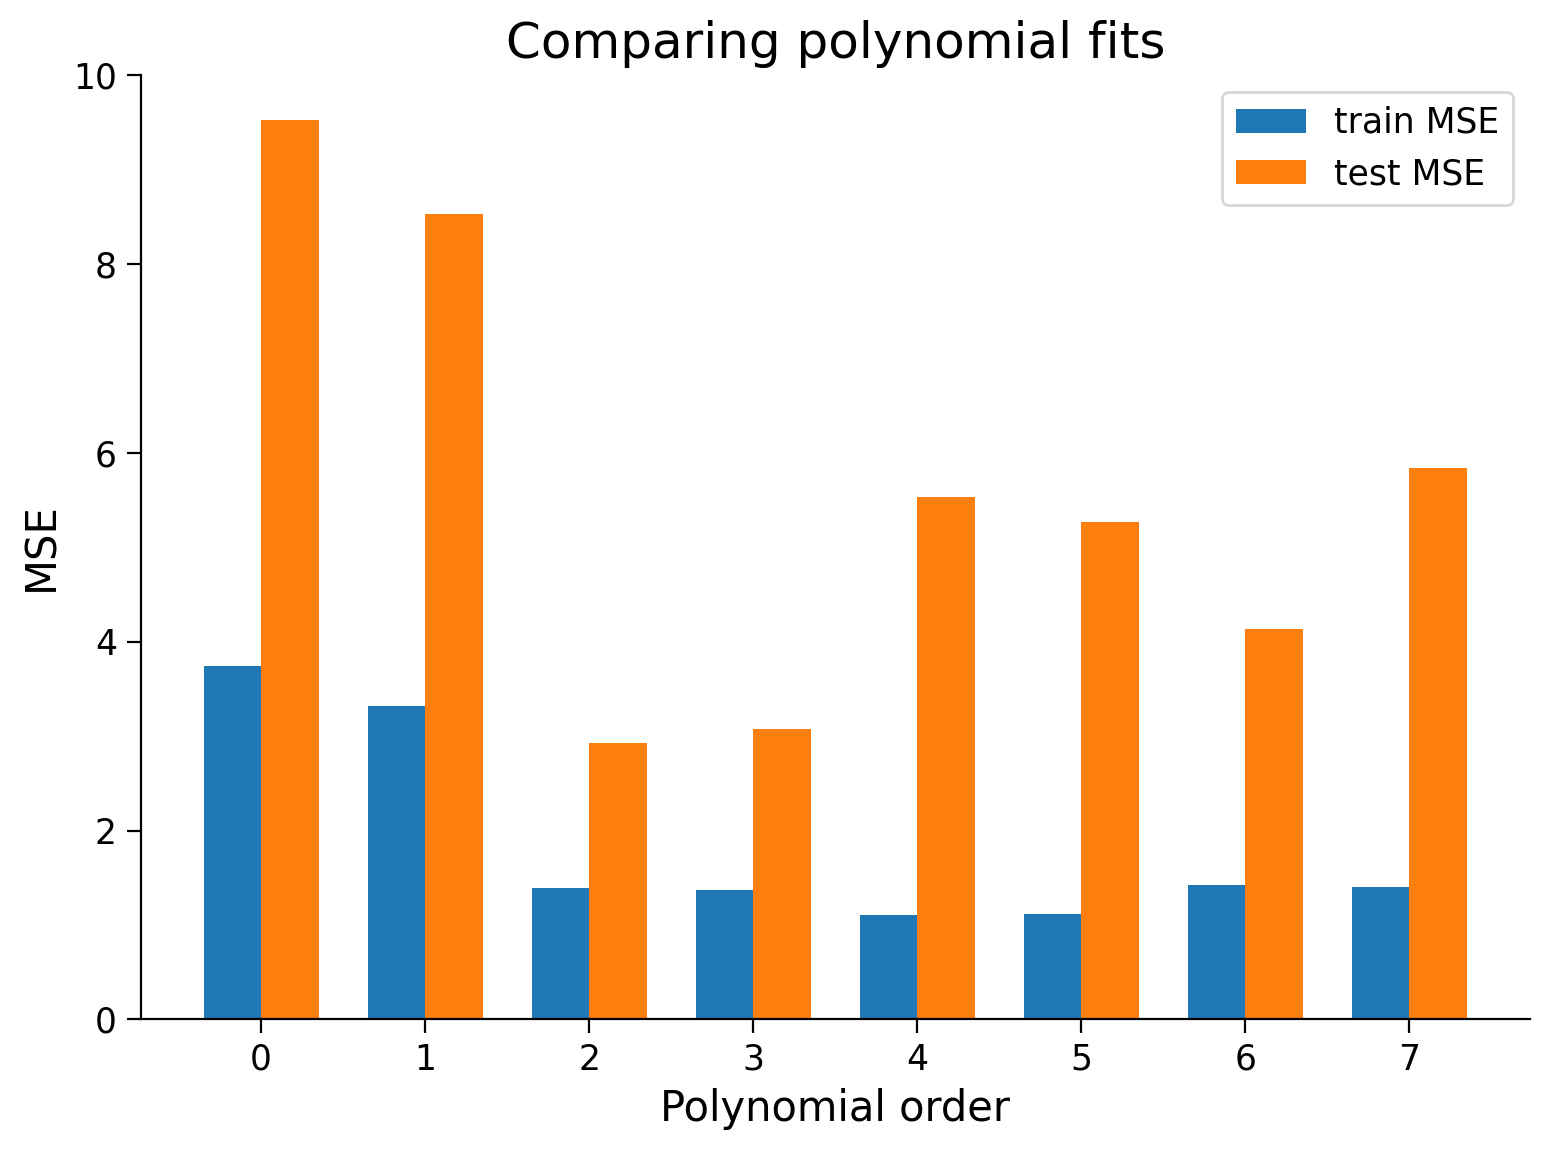

In [139]:
# Compute MSE on training data and test data.
def compute_mse(x_train, x_test, y_train, y_test, theta_hats, max_order):
  """
  Args:
    theta_hats(dict): fitted weights for each polynomial model (dict key is order)
    max_order (scalar): max order of polynomial fit
  Returns:
    ndarray, ndarray: MSE error on training data and test data for each order
  """

  mse_train = evaluate_poly_reg(x_train, y_train, theta_hats, max_order)
  mse_test = evaluate_poly_reg(x_test, y_test, theta_hats, max_order)
  
  return mse_train, mse_test


# Compute train and test MSE
mse_train, mse_test = compute_mse(x_train, x_test, y_train, y_test, theta_hats, max_order)

# Visualize
plot_MSE_poly_fits(mse_train, mse_test, max_order)

##### I dont agree here that we should take minimum based on the MSE of the test set. I believe that we should do something as bootstrapping, to see were is average or common minimum of MSE is. We can do random resampling of the training set to see mean of the MSE 

### Tutorial 6: Model Selection: Cross-validation
##### We will implement cross-validation and use it to compare polynomial regression model

In [141]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [143]:
# Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# Plotting Functions

def plot_cross_validate_MSE(mse_all):
  """ Plot the MSE values for the K_fold cross validation

  Args:
    mse_all (ndarray): an array of size (number of splits, max_order + 1)
  """
  plt.figure()
  plt.boxplot(mse_all, labels=np.arange(0, max_order + 1))

  plt.xlabel('Polynomial Order')
  plt.ylabel('Validation MSE')
  plt.title(f'Validation MSE over {n_splits} splits of the data')
  plt.show()


def plot_AIC(order_list, AIC_list):
  """ Plot the AIC value for fitted polynomials of various orders

  Args:
    order_list (list): list of fitted polynomial orders
    AIC_list (list): list of AIC values corresponding to each polynomial model on order_list
  """
  plt.bar(order_list, AIC_list)
  plt.ylabel('AIC')
  plt.xlabel('polynomial order')
  plt.title('comparing polynomial fits')
  plt.show()

In [145]:
# Helper Functions

def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """

  return np.linalg.inv(x.T @ x) @ x.T @ y


def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """

  # Broadcast to shape (n x 1)
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hats[order] = this_theta

  return theta_hats


def evaluate_poly_reg(x, y, theta_hats, max_order):
    """ Evaluates MSE of polynomial regression models on data

    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      theta_hat (dict): fitted weights for each polynomial model (dict key is order)
      max_order (scalar): max order of polynomial fit

    Returns
      (ndarray): mean squared error for each order, shape (max_order)
    """

    mse = np.zeros((max_order + 1))
    for order in range(0, max_order + 1):
      X_design = make_design_matrix(x, order)
      y_hat = np.dot(X_design, theta_hats[order])
      residuals = y - y_hat
      mse[order] = np.mean(residuals ** 2)

    return mse

### Section 6.1: Cross-validation 


In [147]:
# Generate training data
np.random.seed(0)
n_train_samples = 50
x_train = np.random.uniform(-2, 2.5, n_train_samples)  # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_train_samples)  # sample from a standard normal distribution
y_train = x_train**2 - x_train - 2 + noise

# Generate testing data
n_test_samples = 20
x_test = np.random.uniform(-3, 3, n_test_samples)  # sample from a uniform distribution over [-3, 3)
noise = np.random.randn(n_test_samples)  # sample from a standard normal distribution
y_test = x_test**2 - x_test - 2 + noise

# Fit polynomial regression models
max_order = 5
theta_hats = solve_poly_reg(x_train, y_train, max_order)

In [149]:
def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.
  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits
  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order+1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hats[order] = this_theta

  return theta_hats

In [148]:
def evaluate_poly_reg(x, y, theta_hats, max_order):
  
  mse = np.zeros((max_order + 1))
  for order in range(0, max_order + 1):
    X_design = make_design_matrix(x, order)
    y_hat = np.dot(X_design, theta_hats[order])
    residuals = y - y_hat
    mse[order] = np.mean(residuals ** 2)

  return mse

C:\Users\huawei\AppData\Local\Temp\ipykernel_14808\2007291771.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_all, labels=np.arange(0, max_order + 1))


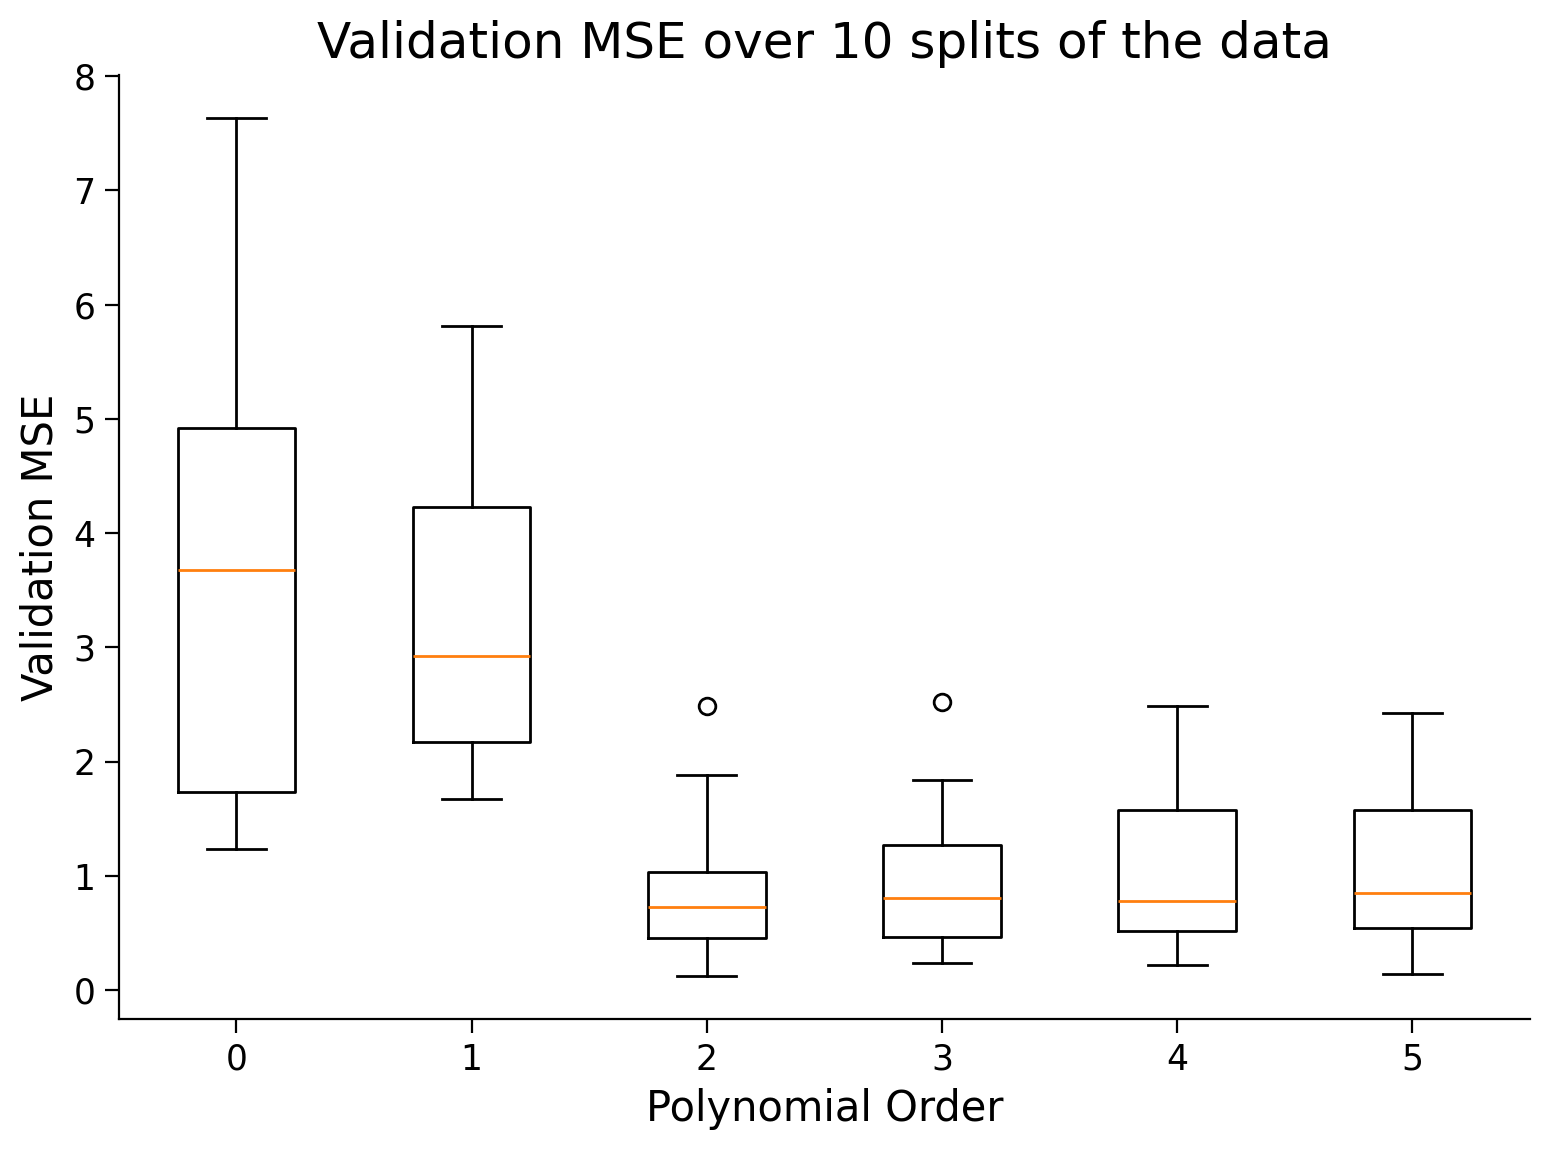

In [160]:
# Compute MSE for k-fold validation for each order polynomial
def cross_validate(x_train, y_train, max_order, n_splits):
  """ 
  Args:
    x_train (ndarray): training data input vector of shape (n_samples)
    y_train (ndarray): training vector of measurements of shape (n_samples)
    max_order (scalar): max order of polynomial fit
    n_split (scalar): number of folds for k-fold validation
  Return:
    ndarray: MSE over splits for each model order, shape (n_splits, max_order + 1)
  """

  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits, max_order + 1))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):

      # Split up the overall training data into cross-validation training and validation sets
      x_cv_train = x_train[train_indices]
      y_cv_train = y_train[train_indices]
      x_cv_val = x_train[val_indices]
      y_cv_val = y_train[val_indices]

      # Fit models
      theta_hats = solve_poly_reg(x_cv_train, y_cv_train, max_order)

      # Compute MSE
      mse_this_split = evaluate_poly_reg(x_cv_val, y_cv_val, theta_hats, max_order)

      mse_all[i_split] = mse_this_split

  return mse_all


# Cross-validate
max_order = 5

n_splits = 10
mse_all = cross_validate(x_train, y_train, max_order, n_splits)

# Visualize
plot_cross_validate_MSE(mse_all)

##### There is also Leave-one-out Cross Validation validation 

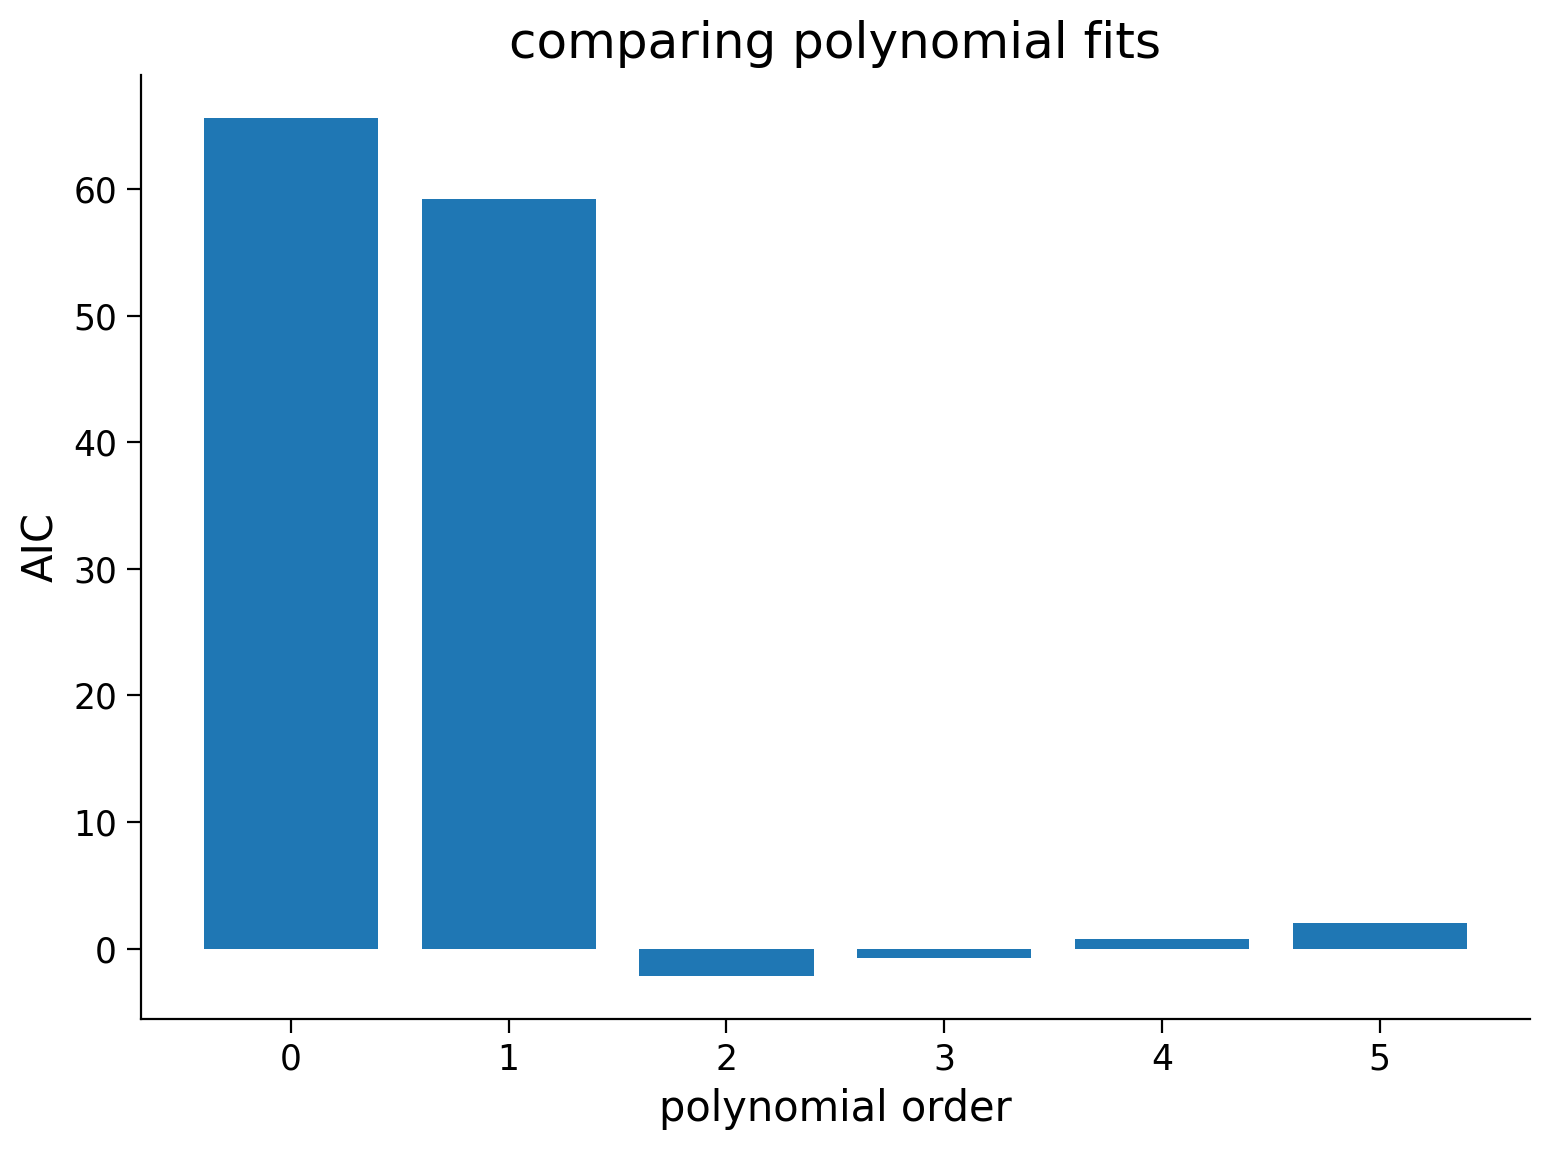

In [161]:
# Compute Akaike’s Information Criterion (AIC)
AIC_list = []
order_list = list(range(max_order + 1))

for order in order_list:

  # Compute predictions for this model
  X_design = make_design_matrix(x_train, order)
  y_hat = np.dot(X_design, theta_hats[order])

  # Compute SSE
  residuals = y_train - y_hat
  sse = np.sum(residuals ** 2)

  # Get K
  K = len(theta_hats[order])

  # Compute AIC
  AIC = 2*K + n_train_samples * np.log(sse / n_train_samples)

  AIC_list.append(AIC)

# Visualize
plt.bar(order_list, AIC_list)

plt.ylabel('AIC')
plt.xlabel('polynomial order')
plt.title('comparing polynomial fits')
plt.show()